In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from scipy import sparse
from scipy import linalg
from scipy.optimize import linear_sum_assignment
import inference
import cluster
import generation
import metrics
from spectral_operators import BetheHessian

%load_ext autoreload
%autoreload 2

In [2]:
# Matplotlib settings

# plt.style.use('seaborn-whitegrid')

basic_line_color = '#808080'
black = '#222222'
darkgray = '#A9A9A9'
highlight = '#00B2EE'

#color0 = '#7570b3'
#color1 = '#d95f02'
#color3 = '#1b9e77'

color0 = '#1f78b4'
color1 = '#b2df8a'
color2 = '#a6cee3'

plt.rc('figure', figsize=(8, 5))
plt.rc('font', size=16)
plt.rc('font', family='sans-serif')
plt.rcParams['font.sans-serif'] = 'verdana'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = basic_line_color
plt.rcParams['xtick.color'] = basic_line_color
plt.rcParams['ytick.color'] = basic_line_color
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['lines.markersize'] = 12

%config InlineBackend.figure_format = 'retina'

In [3]:
def best_score(score_mat, hier):
    groups = [part.k for part in hier]
    pred_lvls, true_lvls = score_mat.shape
    scores = np.zeros(true_lvls)
    n_groups = np.zeros(true_lvls)
    pred_ind, true_ind = linear_sum_assignment(-score_mat)
    for pl, idx in zip(pred_ind, true_ind):
        scores[idx] =  score_mat[pl, idx]
        n_groups[idx] = groups[pl]
    return scores, n_groups

In [4]:
def evecs_from_BetheHessian(A, num_groups=-1, regularizer='BHa',
                              clustermode='KM', norm=False):
    """
    Perform one round of spectral clustering using the Bethe Hessian
    """

    # construct both the positive and the negative variant of the BH
    BH_pos = BetheHessian(A, regularizer)
    BH_neg = BetheHessian(A, regularizer+'n')

    BH_pos.find_k_eigenvectors(num_groups, which='SA')
    BH_neg.find_k_eigenvectors(num_groups, which='SA')

    # combine both sets of eigenvales and eigenvectors and take first k
    combined_evecs = np.hstack([BH_pos.evecs, BH_neg.evecs])
    combined_evals = np.hstack([BH_pos.evals, BH_neg.evals])
    index = np.argsort(combined_evals)
    combined_evecs = combined_evecs[:, index[:num_groups]]

    return combined_evecs

In [5]:
def runExp(n, c_bar, reps, snrs, sym, parameters, fileid='', gamma=0.7):
    for snr in snrs:
        print(f'SNR={snr}')
        tp = 0.
        tr = 0.
        lvl_scores_snr = 0
        n_lvl = 0
        if sym:
            dendro = generation.create2paramGHRG(n, snr, c_bar, 3, 3, gamma)
        else:
            dendro = generation.createAsymGHRG(n, snr, c_bar, 3, 3, gamma)
        num_groups = [part.k for part in dendro]
        for rep in range(reps):
            Ag = dendro.sample_network()
            amis = []
            k = np.max(num_groups)
            combined_evecs = evecs_from_BetheHessian(Ag, num_groups=k)
            for true_part in dendro:
                k = true_part.k
                inf_part = cluster.find_partition(combined_evecs, k, normalization=parameters['BHnorm'])
                ami = metrics.adjusted_mutual_info_score(inf_part.pvec, 
                                                         true_part.pvec_expanded,
                                                         average_method="arithmetic")
                amis.append(ami)
                
            hier = inference.infer_hierarchy(Ag, parameters=parameters)
            score_mat = metrics.calculate_level_comparison_matrix(hier, dendro)
            ls, ng = best_score(score_mat, hier)
            lvl_scores_snr += ls
            nl = score_mat.shape[0]
            n_lvl += nl
            p, r = metrics.calculate_precision_recall(score_mat)
            tp+=p
            tr+=r
            if sym:
                results_file = f'sym_results{fileid}.txt'
            else:
                results_file = f'asym_results{fileid}.txt'
            with open(results_file, 'a') as rfile:
                rfile.write(f'{snr} {p} {r} {nl} {ls[0]} {ls[1]} {ls[2]} {ng[0]} {ng[1]} {ng[2]} ')
                rfile.write(f'{amis[0]} {amis[1]} {amis[2]} \n')


In [6]:
c_bar = 50
n = 3**9
reps = 2
snrs = np.linspace(0, 10, 21)
# snrs = np.linspace(2, 8, 13)
parameters = {}
parameters['reps'] = 20
parameters['noise'] = 2e-2
parameters['BHnorm'] = False
parameters['Lnorm'] = False
parameters['error_threshold'] = 0.5
# fileid = '4-5a'
# fileid = '6-5log333'
# fileid = '7-5logs'
# fileid = '11-5useW'
fileid = '21-5useW3-3'
# fileid = '23-5useW3-2'

In [7]:
for rr in range(0):
    runExp(n, c_bar, reps, snrs, True, parameters, fileid)
    runExp(n, c_bar, reps, snrs, False, parameters, fileid)

In [8]:
# rfile.write(f'{snr} {p} {r} {nl} {ls[0]} {ls[1]} {ls[2]} {ng[0]} {ng[1]} {ng[2]} ')
#                 rfile.write(f'{amis[0]} {amis[1]} {amis[2]} \n')
def read_scores(sym, fileid):
    precision = []
    recall = []
    lvl_scores = []
    n_levels = []
    mean_scores = []
    if sym:
        results_file = f'results_me/sym_results{fileid}.txt'
    else:
        results_file = f'results_me/asym_results{fileid}.txt'
    with open(results_file) as rfile:
        results = np.float64([row.strip().split() for row in rfile.readlines()])
    snrs = np.unique(results[:,0])
    for snr in snrs:
        snr_res = results[results[:, 0]==snr, :]
#         mean_scores.append([np.mean(snr_res[:, i]) for i in range(1,snr_res.shape[1])])
        mean_scores.append(np.mean(snr_res, 0)[1:])
    mean_scores = np.array(mean_scores)
    
    precision = mean_scores[:, 0]
    recall = mean_scores[:, 1]
    n_levels = mean_scores[:, 2]
    lvl_scores = mean_scores[:, 3:6]
    n_groups = mean_scores[:, 6:9]
    lvl_scores_with_k = mean_scores[:, 9:12]
    
    return precision, recall, n_levels, lvl_scores, n_groups, lvl_scores_with_k
    
        


In [9]:
precision, recall, n_levels, lvl_scores, n_groups, lvl_scores_with_k = read_scores(True, fileid)
precision_a, recall_a, n_levels_a, lvl_scores_a, n_groups_a, lvl_scores_with_k_a = read_scores(False, fileid)
print(n_levels, n_levels_a, np.max(n_levels), np.max(n_levels_a))

[1.   1.   1.   1.02 1.18 2.   2.02 2.78 3.18 3.   3.   3.02 3.   3.
 3.   3.   3.   3.   3.   3.   3.  ] [1.   1.   1.   1.   1.02 1.96 2.02 2.12 3.3  3.26 3.14 3.12 3.02 3.14
 3.04 3.06 3.06 3.08 3.04 3.08 3.06] 3.18 3.3


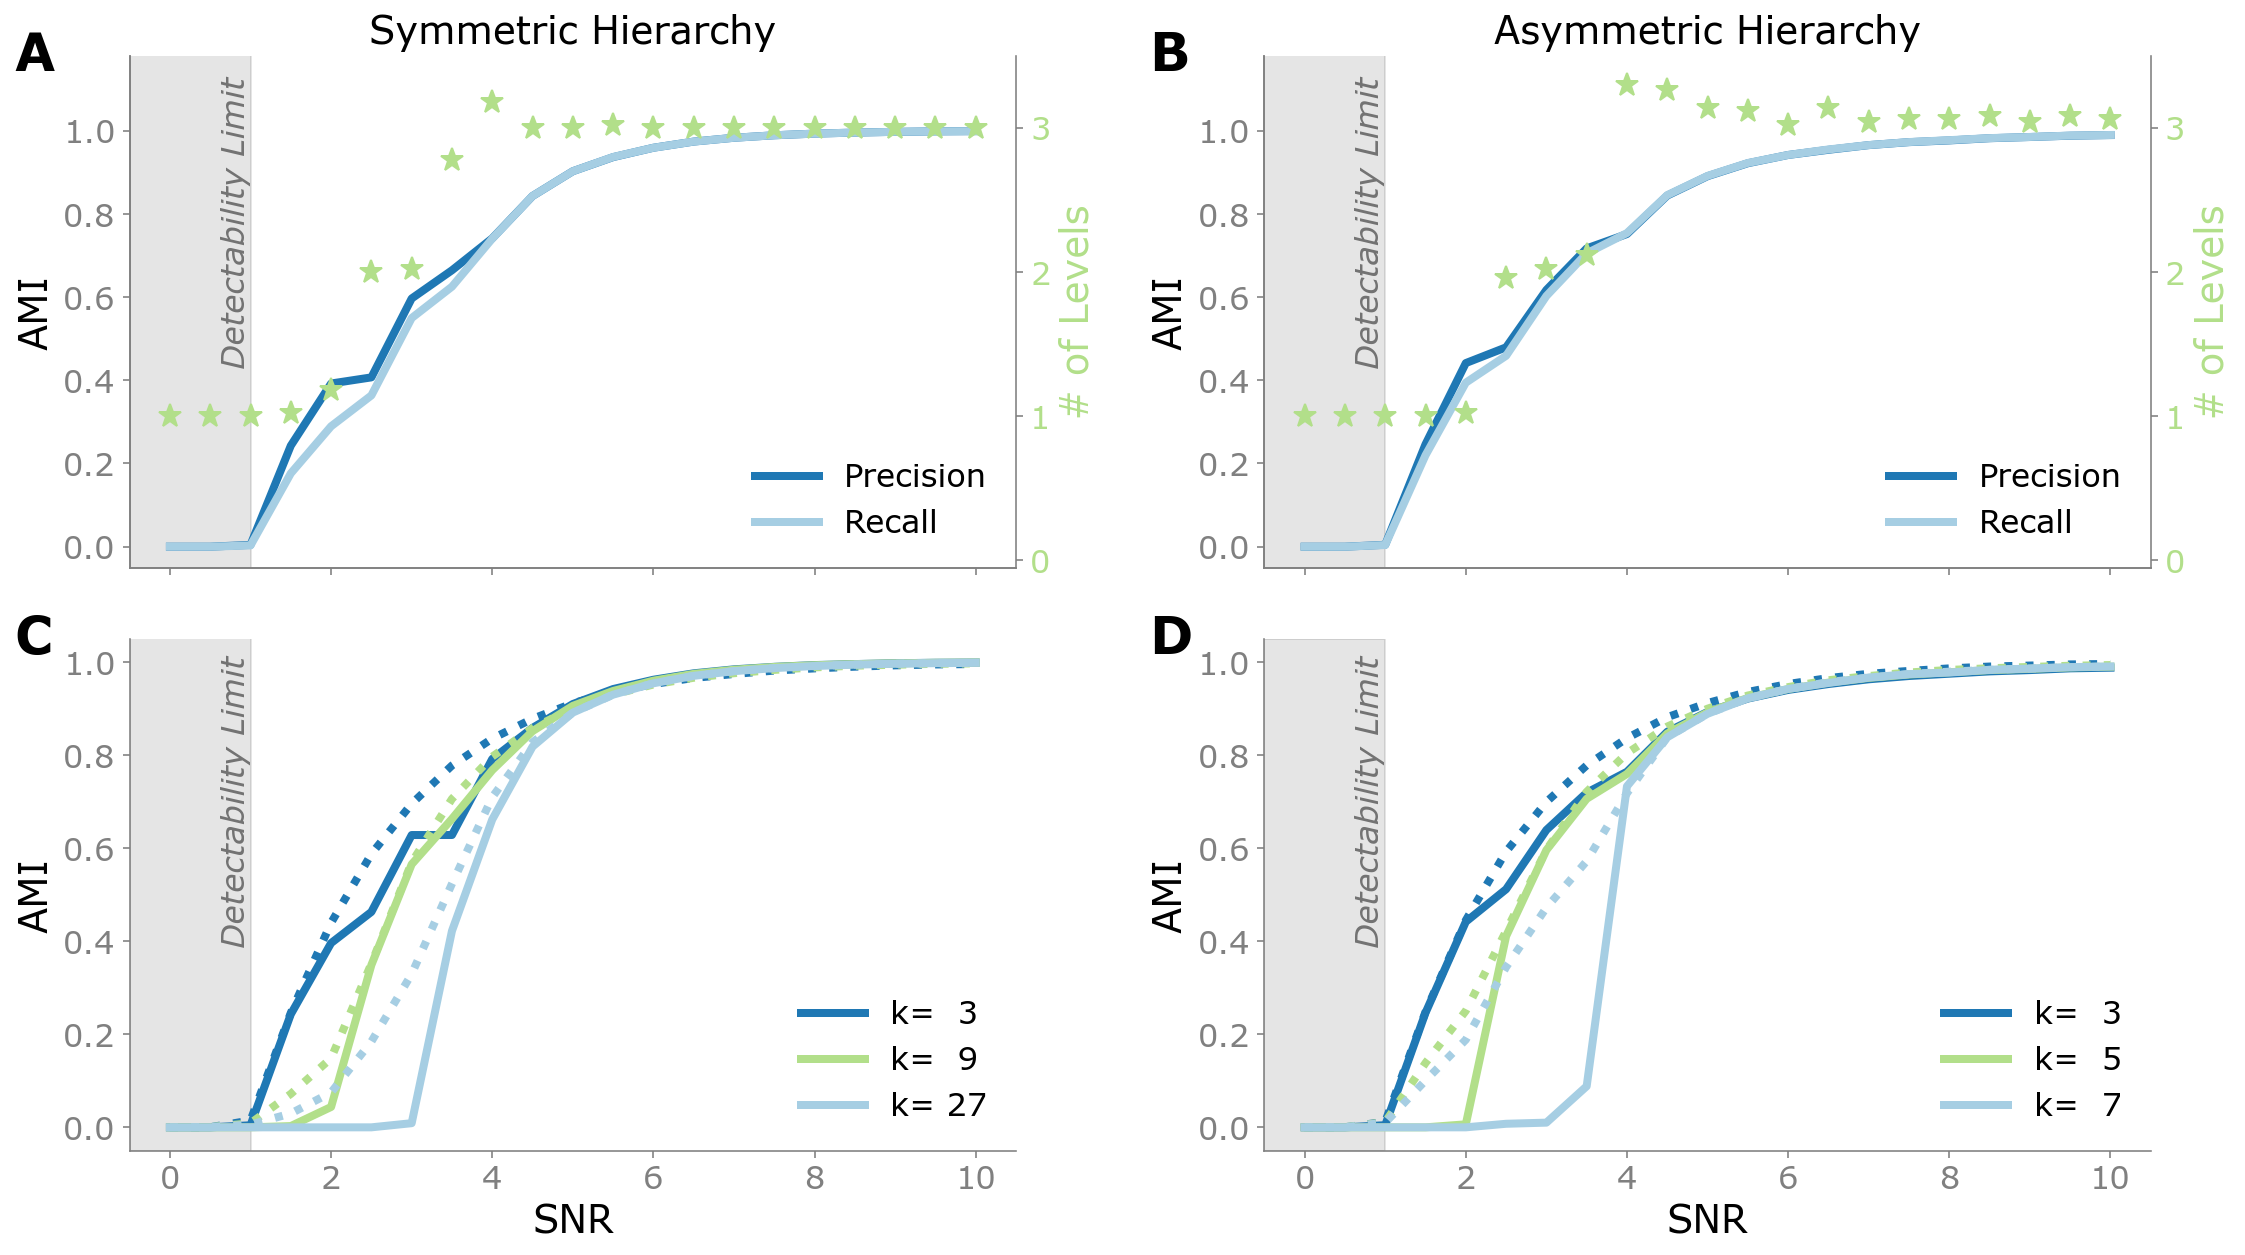

In [146]:
precision, recall, n_levels, lvl_scores, n_groups, lvl_scores_with_k = read_scores(True, fileid)
precision_a, recall_a, n_levels_a, lvl_scores_a, n_groups_a, lvl_scores_with_k_a = read_scores(False, fileid)

fig, axs = plt.subplots(2, 2, figsize=(16, 9), sharex=True)

colors = [color0, color1, color2]

#symmetric

axs[0, 0].plot(snrs, precision, color=color0, label='Precision')
axs[0, 0].plot(snrs, recall, color=color2, label='Recall')
# axs[0, 0].set_xlabel('SNR')
axs[0, 0].set_ylabel('AMI')
axs[0, 0].set_title('Symmetric Hierarchy')
axs[0, 0].legend(frameon=False)

axs[0, 0].annotate('A', (-0.13, 1), xycoords='axes fraction', va='center', size=26, weight='bold')

rect = patches.Rectangle((-0.5,-0.05), 1.5, 1.5, color='black', alpha=0.1)
axs[0, 0].add_patch(rect)
axs[0, 0].text(1, 0.78, 'Detectability Limit', rotation=90, va='center',
               ha='right', fontstyle='italic', alpha=0.5)
axs[0, 0].set_ylim(-0.05, 1.18)
axs[0, 0].set_xlim(-0.5, 10.5)

ax2 = axs[0, 0].twinx()
ax2.plot(snrs, n_levels, '*', color=color1)
ax2.set_ylabel('# of Levels', color=color1)
ax2.spines['right'].set_visible(True)
ax2.tick_params(axis='y', labelcolor=color1)
ax2.set_ylim(-0.05, 3.5)

if fileid.endswith('4'):
    group_sizes = [4, 16, 64]
else:
    group_sizes = [3, 9, 27]
for i in range(3):
    axs[1, 0].plot(snrs, lvl_scores[:, i], color=colors[i], label=f'k={group_sizes[i]:3}')
    axs[1, 0].plot(snrs, lvl_scores_with_k[:, i], color=colors[i], ls=':')
axs[1, 0].set_xlabel('SNR')
axs[1, 0].set_ylabel('AMI')
axs[1, 0].legend(frameon=False)

rect = patches.Rectangle((-0.5,-0.05), 1.5, 1.5, color='black', alpha=0.1)
axs[1, 0].add_patch(rect)
axs[1, 0].text(1, 0.7, 'Detectability Limit', rotation=90, va='center',
               ha='right', fontstyle='italic', alpha=0.5)
axs[1, 0].set_ylim(-0.05, 1.05)
axs[1, 0].set_xlim(-0.5, 10.5)

axs[1, 0].annotate('C', (-0.13, 1), xycoords='axes fraction', va='center', size=26, weight='bold')

# asymmetric

axs[0, 1].plot(snrs, precision_a, color=color0, label='Precision')
axs[0, 1].plot(snrs, recall_a, color=color2, label='Recall')
# axs[0, 1].set_xlabel('SNR')
axs[0, 1].set_ylabel('AMI')
axs[0, 1].set_title('Asymmetric Hierarchy')
axs[0, 1].legend(frameon=False)

axs[0, 1].annotate('B', (-0.13, 1), xycoords='axes fraction', va='center', size=26, weight='bold')

rect = patches.Rectangle((-0.5,-0.05), 1.5, 1.5, color='black', alpha=0.1)
axs[0, 1].add_patch(rect)
axs[0, 1].text(1, 0.78, 'Detectability Limit', rotation=90, va='center',
               ha='right', fontstyle='italic', alpha=0.5)
axs[0, 1].set_ylim(-0.05, 1.18)
axs[0, 1].set_xlim(-0.5, 10.5)

ax2 = axs[0, 1].twinx()
ax2.plot(snrs, n_levels_a, '*', color=color1)
ax2.set_ylabel('# of Levels', color=color1)
ax2.spines['right'].set_visible(True)
ax2.tick_params(axis='y', labelcolor=color1)
ax2.set_ylim(-0.05, 3.5)

if fileid.endswith('4'):
    group_sizes = [4, 7, 10]
else:
    group_sizes = [3, 5, 7]
for i in range(3):
    axs[1, 1].plot(snrs, lvl_scores_a[:, i], color=colors[i], label=f'k={group_sizes[i]:3}')
    axs[1, 1].plot(snrs, lvl_scores_with_k_a[:, i], color=colors[i], ls=':')
axs[1, 1].set_xlabel('SNR')
axs[1, 1].set_ylabel('AMI')
axs[1, 1].legend(frameon=False)

rect = patches.Rectangle((-0.5,-0.05), 1.5, 1.1, color='black', alpha=0.1)
axs[1, 1].add_patch(rect)
axs[1, 1].text(1, 0.7, 'Detectability Limit', rotation=90, va='center',
               ha='right', fontstyle='italic', alpha=0.5)
axs[1, 1].set_ylim(-0.05, 1.05)
axs[1, 1].set_xlim(-0.5, 10.5)

axs[1, 1].annotate('D', (-0.13, 1), xycoords='axes fraction', va='center', size=26, weight='bold')

plt.tight_layout()
plt.savefig(f'Figure9_{fileid}.pdf')

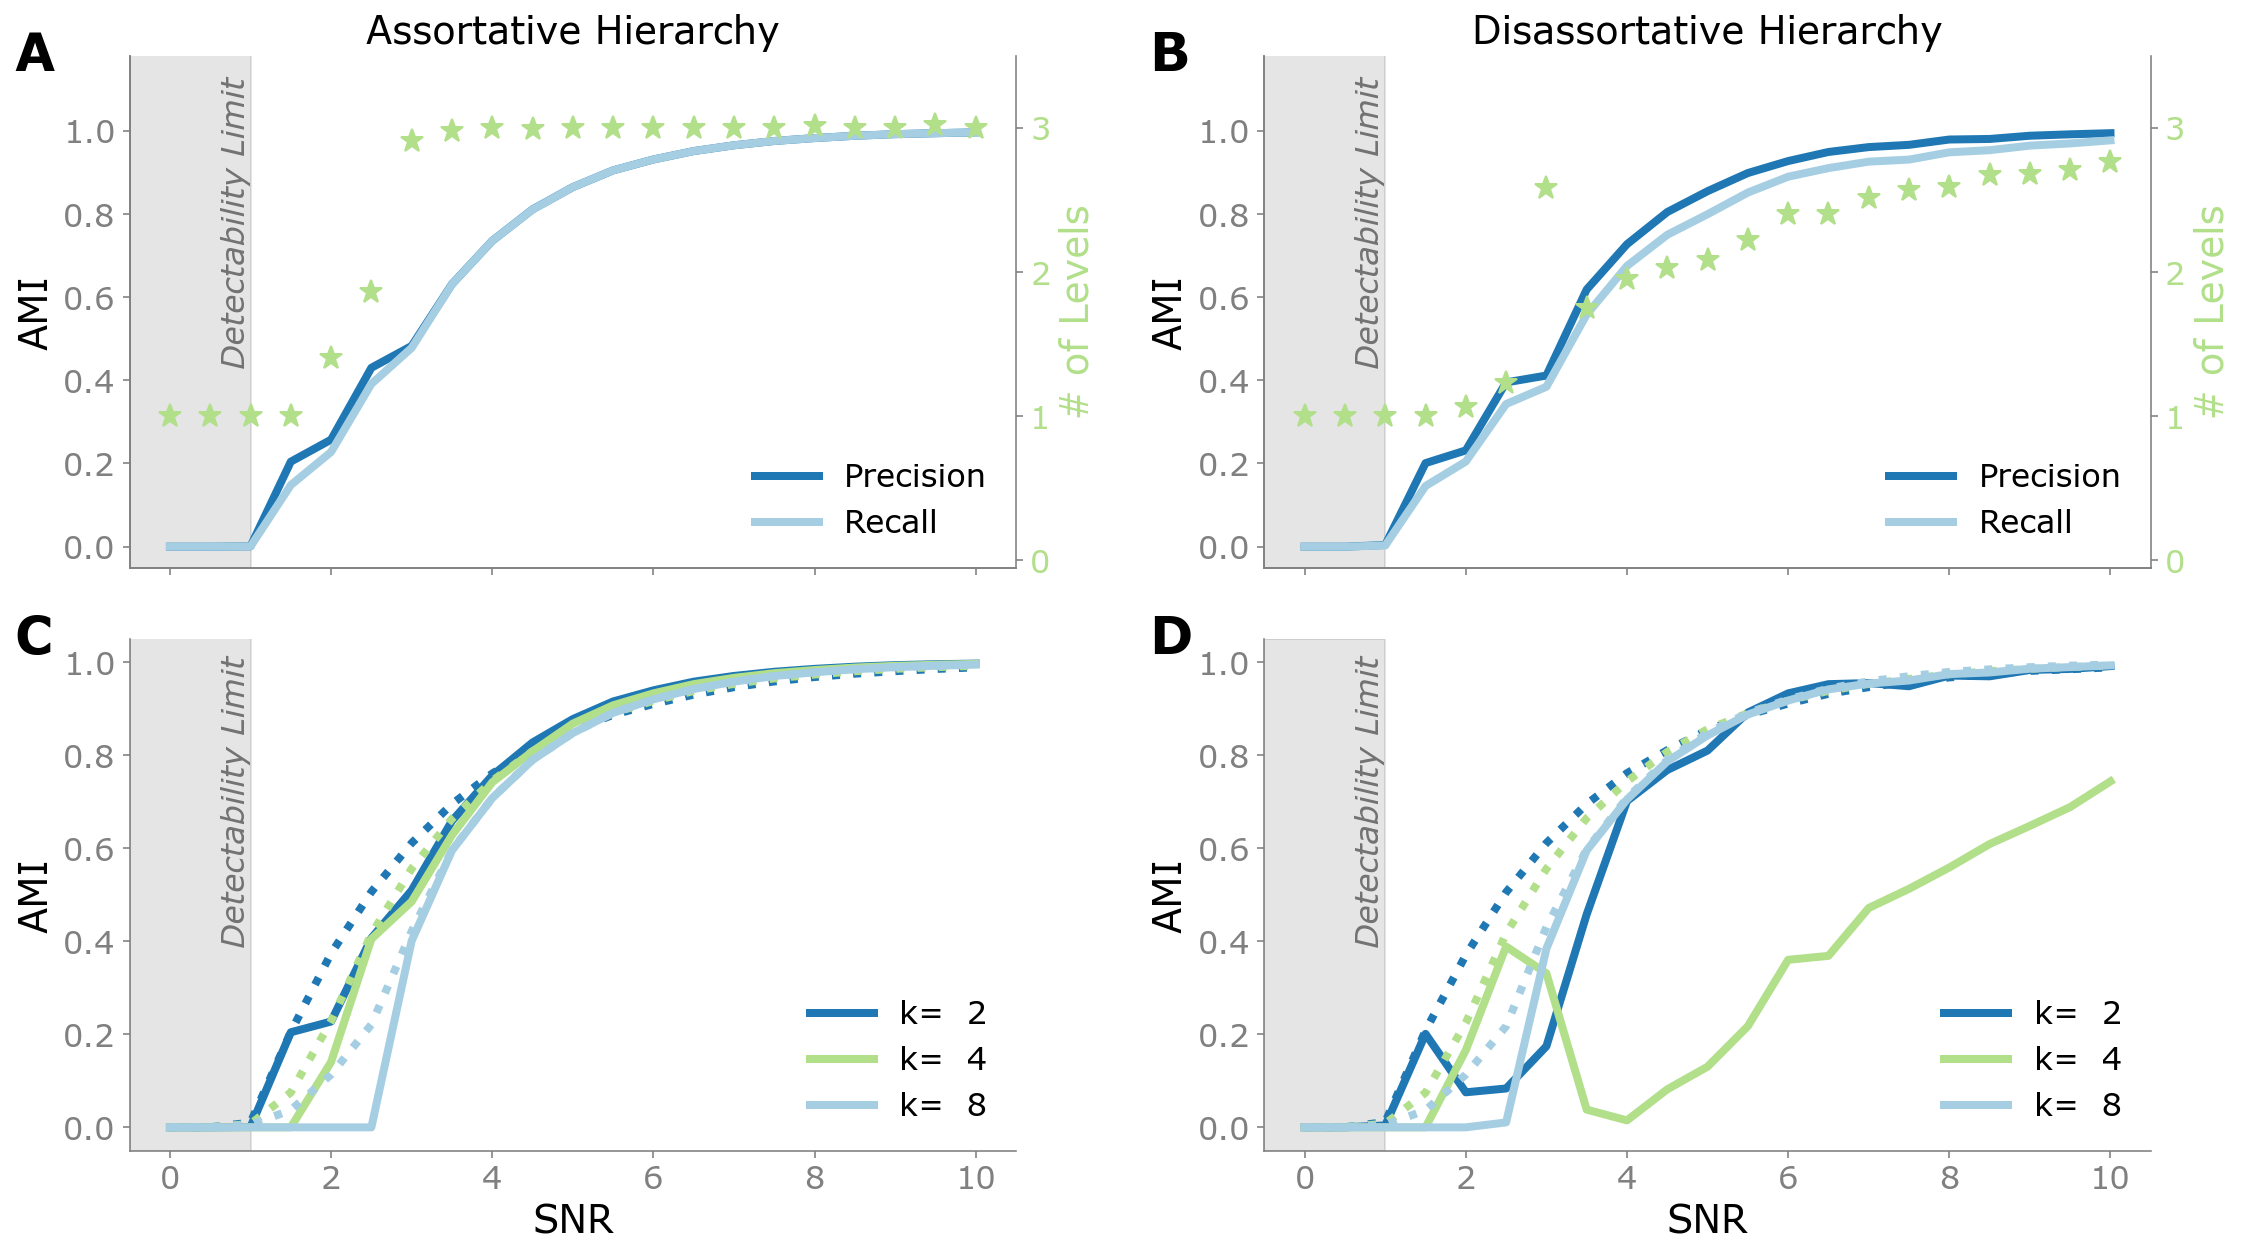

In [10]:
fileid = 'useW'
precision, recall, n_levels, lvl_scores, n_groups, lvl_scores_with_k = read_scores(True, fileid)
fileid = 'useW_and_reverse'
precision_a, recall_a, n_levels_a, lvl_scores_a, n_groups_a, lvl_scores_with_k_a = read_scores(True, fileid)

fig, axs = plt.subplots(2, 2, figsize=(16, 9), sharex=True)

colors = [color0, color1, color2]

#symmetric

axs[0, 0].plot(snrs, precision, color=color0, label='Precision')
axs[0, 0].plot(snrs, recall, color=color2, label='Recall')
# axs[0, 0].set_xlabel('SNR')
axs[0, 0].set_ylabel('AMI')
axs[0, 0].set_title('Assortative Hierarchy')
axs[0, 0].legend(frameon=False)

axs[0, 0].annotate('A', (-0.13, 1), xycoords='axes fraction', va='center', size=26, weight='bold')

rect = patches.Rectangle((-0.5,-0.05), 1.5, 1.5, color='black', alpha=0.1)
axs[0, 0].add_patch(rect)
axs[0, 0].text(1, 0.78, 'Detectability Limit', rotation=90, va='center',
               ha='right', fontstyle='italic', alpha=0.5)
axs[0, 0].set_ylim(-0.05, 1.18)
axs[0, 0].set_xlim(-0.5, 10.5)

ax2 = axs[0, 0].twinx()
ax2.plot(snrs, n_levels, '*', color=color1)
ax2.set_ylabel('# of Levels', color=color1)
ax2.spines['right'].set_visible(True)
ax2.tick_params(axis='y', labelcolor=color1)
ax2.set_ylim(-0.05, 3.5)

group_sizes = [2, 4, 8]
for i in range(3):
    axs[1, 0].plot(snrs, lvl_scores[:, i], color=colors[i], label=f'k={group_sizes[i]:3}')
    axs[1, 0].plot(snrs, lvl_scores_with_k[:, i], color=colors[i], ls=':')
axs[1, 0].set_xlabel('SNR')
axs[1, 0].set_ylabel('AMI')
axs[1, 0].legend(frameon=False)

rect = patches.Rectangle((-0.5,-0.05), 1.5, 1.5, color='black', alpha=0.1)
axs[1, 0].add_patch(rect)
axs[1, 0].text(1, 0.7, 'Detectability Limit', rotation=90, va='center',
               ha='right', fontstyle='italic', alpha=0.5)
axs[1, 0].set_ylim(-0.05, 1.05)
axs[1, 0].set_xlim(-0.5, 10.5)

axs[1, 0].annotate('C', (-0.13, 1), xycoords='axes fraction', va='center', size=26, weight='bold')

# asymmetric

axs[0, 1].plot(snrs, precision_a, color=color0, label='Precision')
axs[0, 1].plot(snrs, recall_a, color=color2, label='Recall')
# axs[0, 1].set_xlabel('SNR')
axs[0, 1].set_ylabel('AMI')
axs[0, 1].set_title('Disassortative Hierarchy')
axs[0, 1].legend(frameon=False)

axs[0, 1].annotate('B', (-0.13, 1), xycoords='axes fraction', va='center', size=26, weight='bold')

rect = patches.Rectangle((-0.5,-0.05), 1.5, 1.5, color='black', alpha=0.1)
axs[0, 1].add_patch(rect)
axs[0, 1].text(1, 0.78, 'Detectability Limit', rotation=90, va='center',
               ha='right', fontstyle='italic', alpha=0.5)
axs[0, 1].set_ylim(-0.05, 1.18)
axs[0, 1].set_xlim(-0.5, 10.5)

ax2 = axs[0, 1].twinx()
ax2.plot(snrs, n_levels_a, '*', color=color1)
ax2.set_ylabel('# of Levels', color=color1)
ax2.spines['right'].set_visible(True)
ax2.tick_params(axis='y', labelcolor=color1)
ax2.set_ylim(-0.05, 3.5)

group_sizes = [2, 4, 8]
for i in range(3):
    axs[1, 1].plot(snrs, lvl_scores_a[:, i], color=colors[i], label=f'k={group_sizes[i]:3}')
    axs[1, 1].plot(snrs, lvl_scores_with_k_a[:, i], color=colors[i], ls=':')
axs[1, 1].set_xlabel('SNR')
axs[1, 1].set_ylabel('AMI')
axs[1, 1].legend(frameon=False)

rect = patches.Rectangle((-0.5,-0.05), 1.5, 1.1, color='black', alpha=0.1)
axs[1, 1].add_patch(rect)
axs[1, 1].text(1, 0.7, 'Detectability Limit', rotation=90, va='center',
               ha='right', fontstyle='italic', alpha=0.5)
axs[1, 1].set_ylim(-0.05, 1.05)
axs[1, 1].set_xlim(-0.5, 10.5)

axs[1, 1].annotate('D', (-0.13, 1), xycoords='axes fraction', va='center', size=26, weight='bold')

plt.tight_layout()
plt.savefig(f'Figure9_{fileid}.pdf')

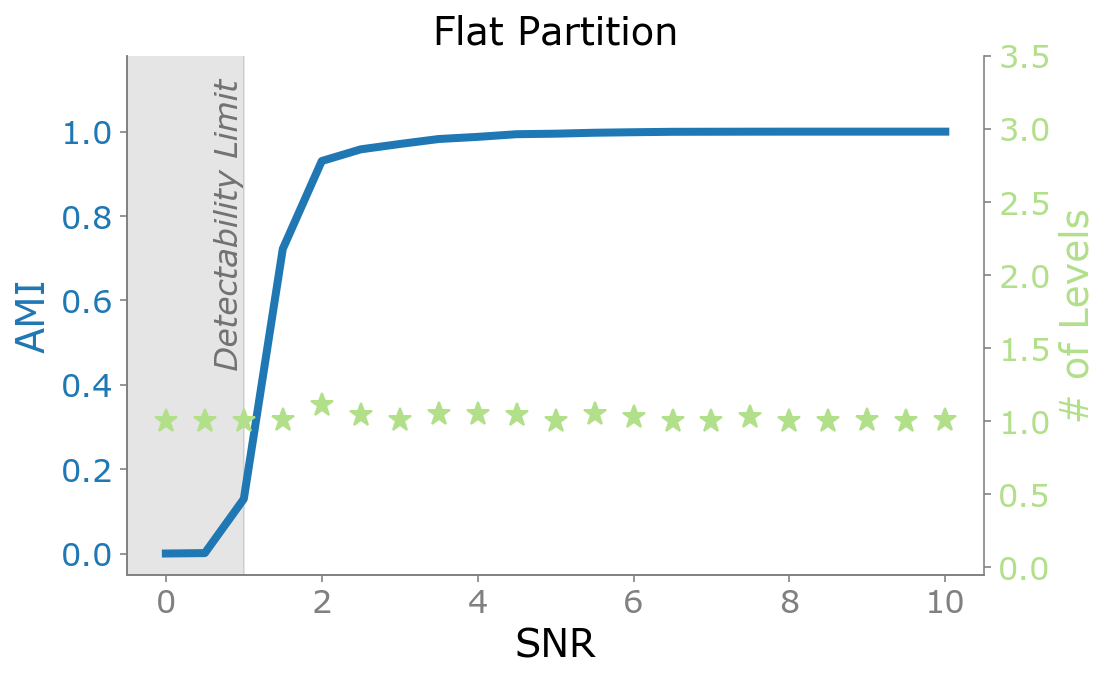

In [21]:
fileid = 'flat1-64'
precision, recall, n_levels, lvl_scores, n_groups, lvl_scores_with_k = read_scores(True, fileid)

fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=True)

colors = [color0, color1, color2]

#symmetric

# axs.plot(snrs, precision, color=color0, label='Precision')
axs.plot(snrs, recall, color=color0, label='AMI')
# axs[0, 0].set_xlabel('SNR')
axs.set_ylabel('AMI', color=color0)
axs.set_xlabel('SNR')
axs.set_title('Flat Partition')
axs.tick_params(axis='y', labelcolor=color0)
# axs.legend(frameon=False)

# axs.annotate('A', (-0.13, 1), xycoords='axes fraction', va='center', size=26, weight='bold')

rect = patches.Rectangle((-0.5,-0.05), 1.5, 1.5, color='black', alpha=0.1)
axs.add_patch(rect)
axs.text(1, 0.78, 'Detectability Limit', rotation=90, va='center',
               ha='right', fontstyle='italic', alpha=0.5)
axs.set_ylim(-0.05, 1.18)
axs.set_xlim(-0.5, 10.5)

ax2 = axs.twinx()
ax2.plot(snrs, n_levels, '*', color=color1)
ax2.set_ylabel('# of Levels', color=color1)
ax2.spines['right'].set_visible(True)
ax2.tick_params(axis='y', labelcolor=color1)
ax2.set_ylim(-0.05, 3.5)

# group_sizes = [2, 4, 8]
# for i in range(3):
#     axs[1, 0].plot(snrs, lvl_scores[:, i], color=colors[i], label=f'k={group_sizes[i]:3}')
#     axs[1, 0].plot(snrs, lvl_scores_with_k[:, i], color=colors[i], ls=':')
# axs[1, 0].set_xlabel('SNR')
# axs[1, 0].set_ylabel('AMI')
# axs[1, 0].legend(frameon=False)

# rect = patches.Rectangle((-0.5,-0.05), 1.5, 1.5, color='black', alpha=0.1)
# axs[1, 0].add_patch(rect)
# axs[1, 0].text(1, 0.7, 'Detectability Limit', rotation=90, va='center',
#                ha='right', fontstyle='italic', alpha=0.5)
# axs[1, 0].set_ylim(-0.05, 1.05)
# axs[1, 0].set_xlim(-0.5, 10.5)

# axs[1, 0].annotate('C', (-0.13, 1), xycoords='axes fraction', va='center', size=26, weight='bold')


plt.tight_layout()
plt.savefig(f'Figure_{fileid}.pdf')

In [76]:
def read_mean_scores(sym, fileid):
    precision = []
    recall = []
    lvl_scores = []
    n_levels = []
    mean_scores = []
    if sym:
        results_file = f'results_me/sym_results{fileid}.txt'
    else:
        results_file = f'results_me/asym_results{fileid}.txt'
    with open(results_file) as rfile:
        results = np.float64([row.strip().split() for row in rfile.readlines()])
    snrs = np.unique(results[:,0])
    for snr in snrs:
        snr_res = results[results[:, 0]==snr, :]
#         mean_scores.append([np.mean(snr_res[:, i]) for i in range(1,snr_res.shape[1])])
        mean_scores.append(np.mean(snr_res, 0))
    mean_scores = np.array(mean_scores)
    
    return mean_scores

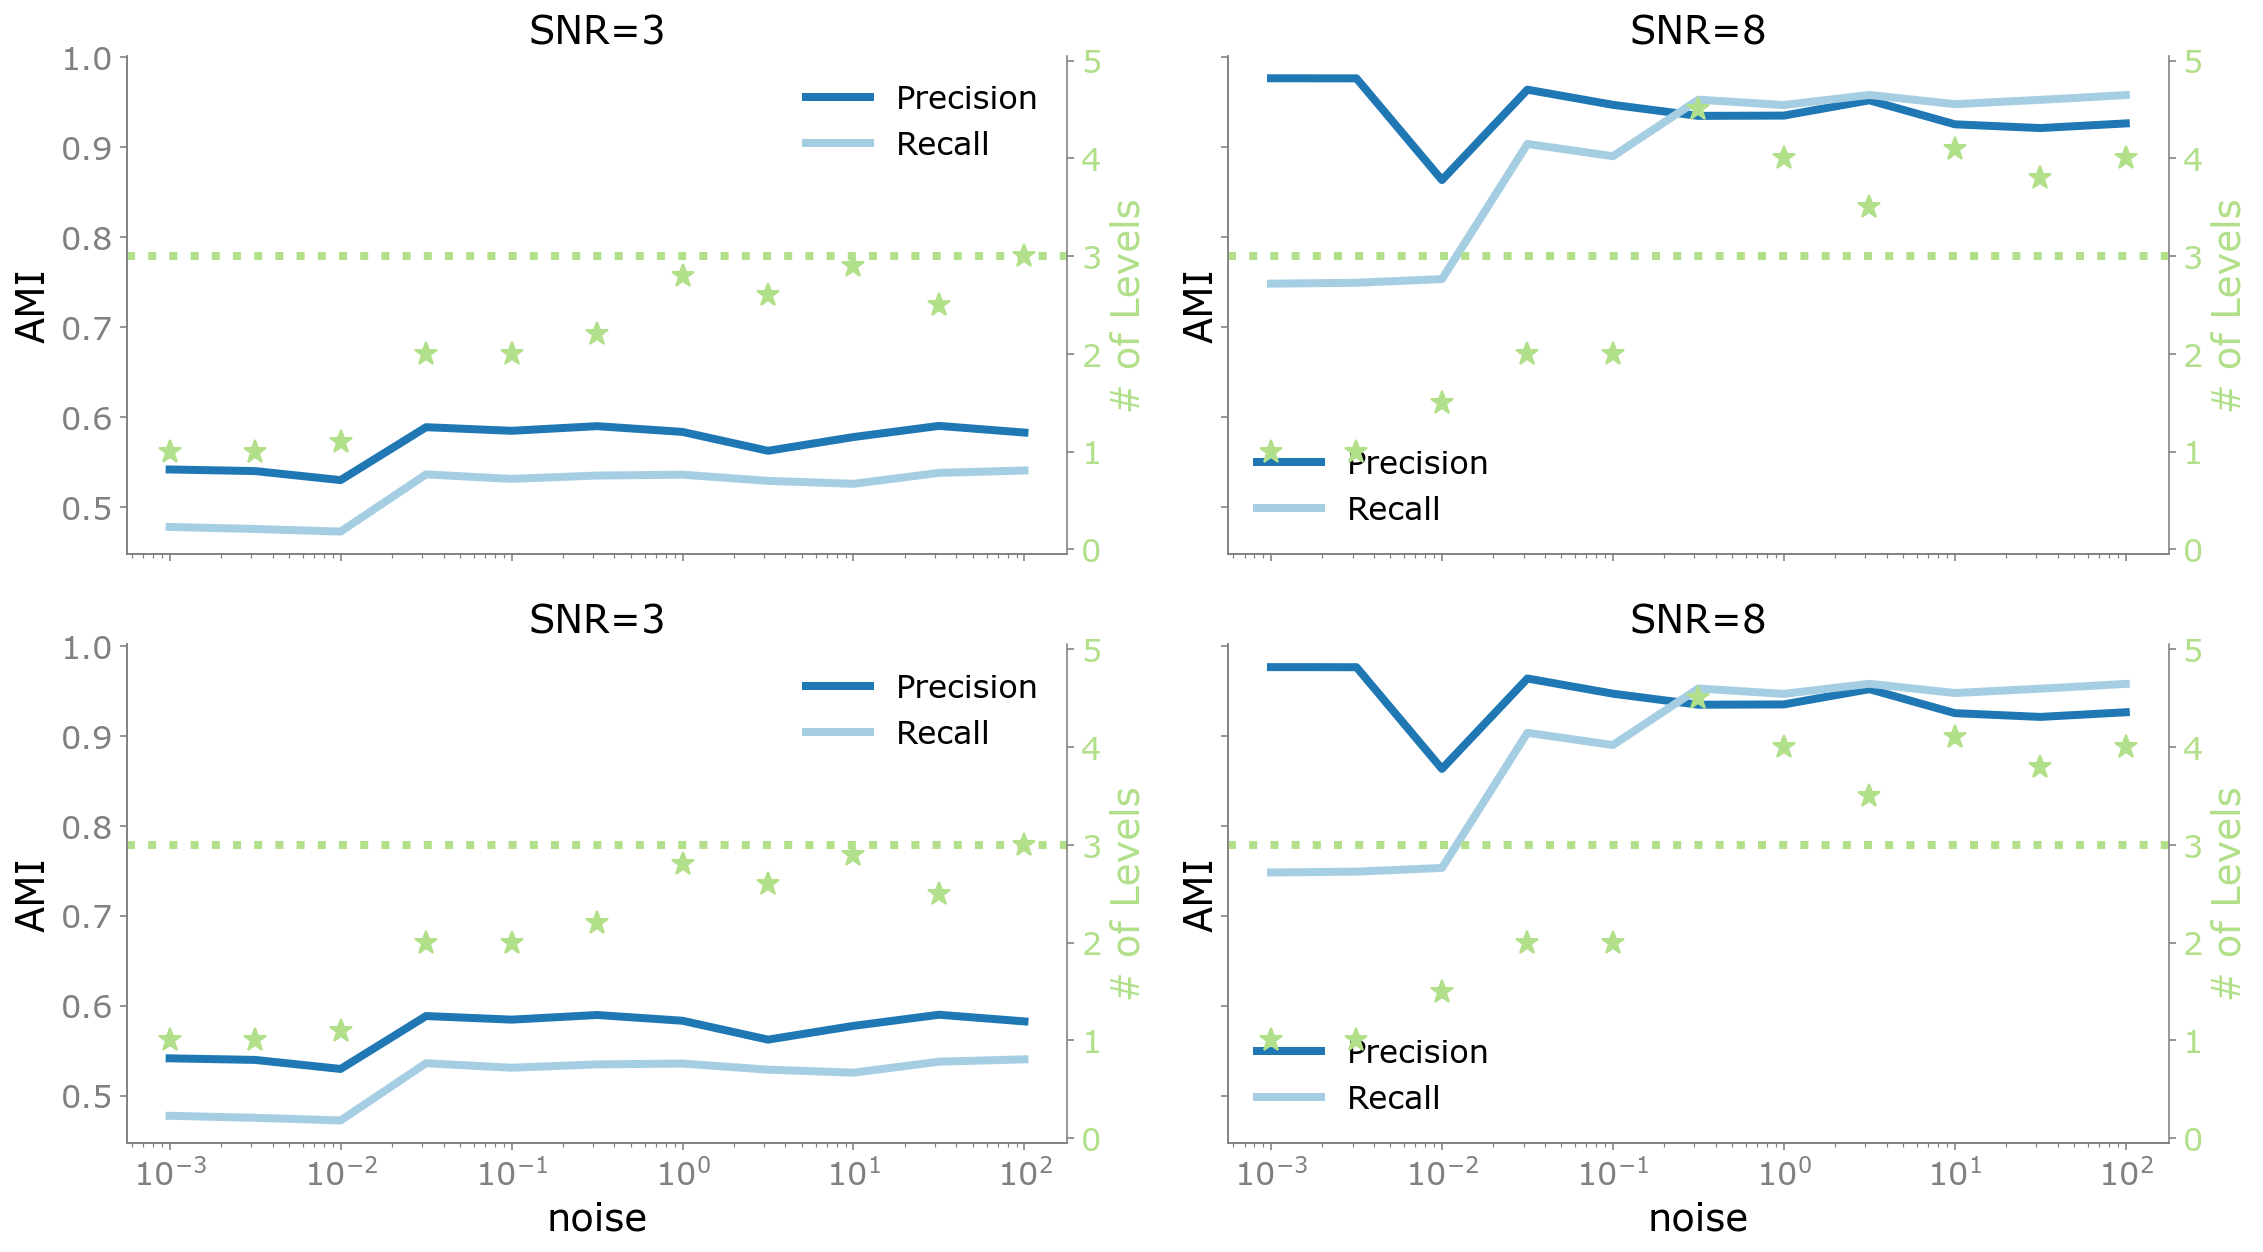

In [55]:
fig, axs = plt.subplots(2, 2, figsize=(16, 9), sharex=True, sharey=True)
snrs = np.array([2, 3, 4, 8])
snrs = np.array([3, 8, 3, 8])
npows = np.linspace(-3, 0, 25)
npows = np.linspace(-3, 2, 11)

# fileid = f'13-5noiseW{npows[0]:.4f}'
fileid = f'18-5noiseW4beta{npows[0]:.4f}'
mean_scores = read_mean_scores(True, fileid)
rows, cols = mean_scores.shape

scores = np.empty((len(npows)*rows, cols+1))
# scores[:rows, 0] = npows[0]
# scores[:rows, 1:] = mean_scores

# precision = mean_scores[:, 0]
# recall = mean_scores[:, 1]
# n_levels = mean_scores[:, 2]
# lvl_scores = mean_scores[:, 3:6]
# n_groups = mean_scores[:, 6:9]
# lvl_scores_with_k = mean_scores[:, 9:12]

for ni, npow in enumerate(npows):
    try:
#         print(f'Noise = {10**npow:}')
#         fileid = f'13-5noiseW{npow:.4f}'
        fileid = f'18-5noiseW4beta{npow:.4f}'
        mean_scores = read_mean_scores(True, fileid)
#         print(mean_scores.shape)
        scores[ni*rows:(ni+1)*rows, 0] = npow
        scores[ni*rows:(ni+1)*rows, 1:] = mean_scores
    except ValueError:
        print(f'Noise = {10**npow:}')
        scores = scores[:ni*rows, :]
        break

# print('scores read')
    
for snr, ax in zip(snrs, axs.ravel()):

#     print(f'snr={snr}')
    snr_scores = scores[scores[:, 1]==snr, :]
#     print(snr_scores.shape)
    npows = snr_scores[:, 0]
    precision = snr_scores[:, 2]
    recall = snr_scores[:, 3]
    n_levels = snr_scores[:, 4]
    
    ax.semilogx(10**npows, precision, color=color0, label='Precision')
    ax.semilogx(10**npows, recall, color=color2, label='Recall')
    # axs[0, 0].set_xlabel('SNR')
    ax.set(ylabel='AMI', title=f'SNR={snr}')
    ax.legend(frameon=False)
    
    ax2 = ax.twinx()
    ax2.semilogx(10**npows, n_levels, '*', color=color1)
    ax2.set_ylabel('# of Levels', color=color1)
    ax2.spines['right'].set_visible(True)
    ax2.tick_params(axis='y', labelcolor=color1)
    ax2.set_ylim(-0.05, 5.05)
    ax2.axhline(3, ls=':', color=color1)
axs[1,1].set(xlabel='noise')
axs[1,0].set(xlabel='noise')
plt.tight_layout()
plt.savefig(f'NoisePRLevels_{fileid}.pdf')

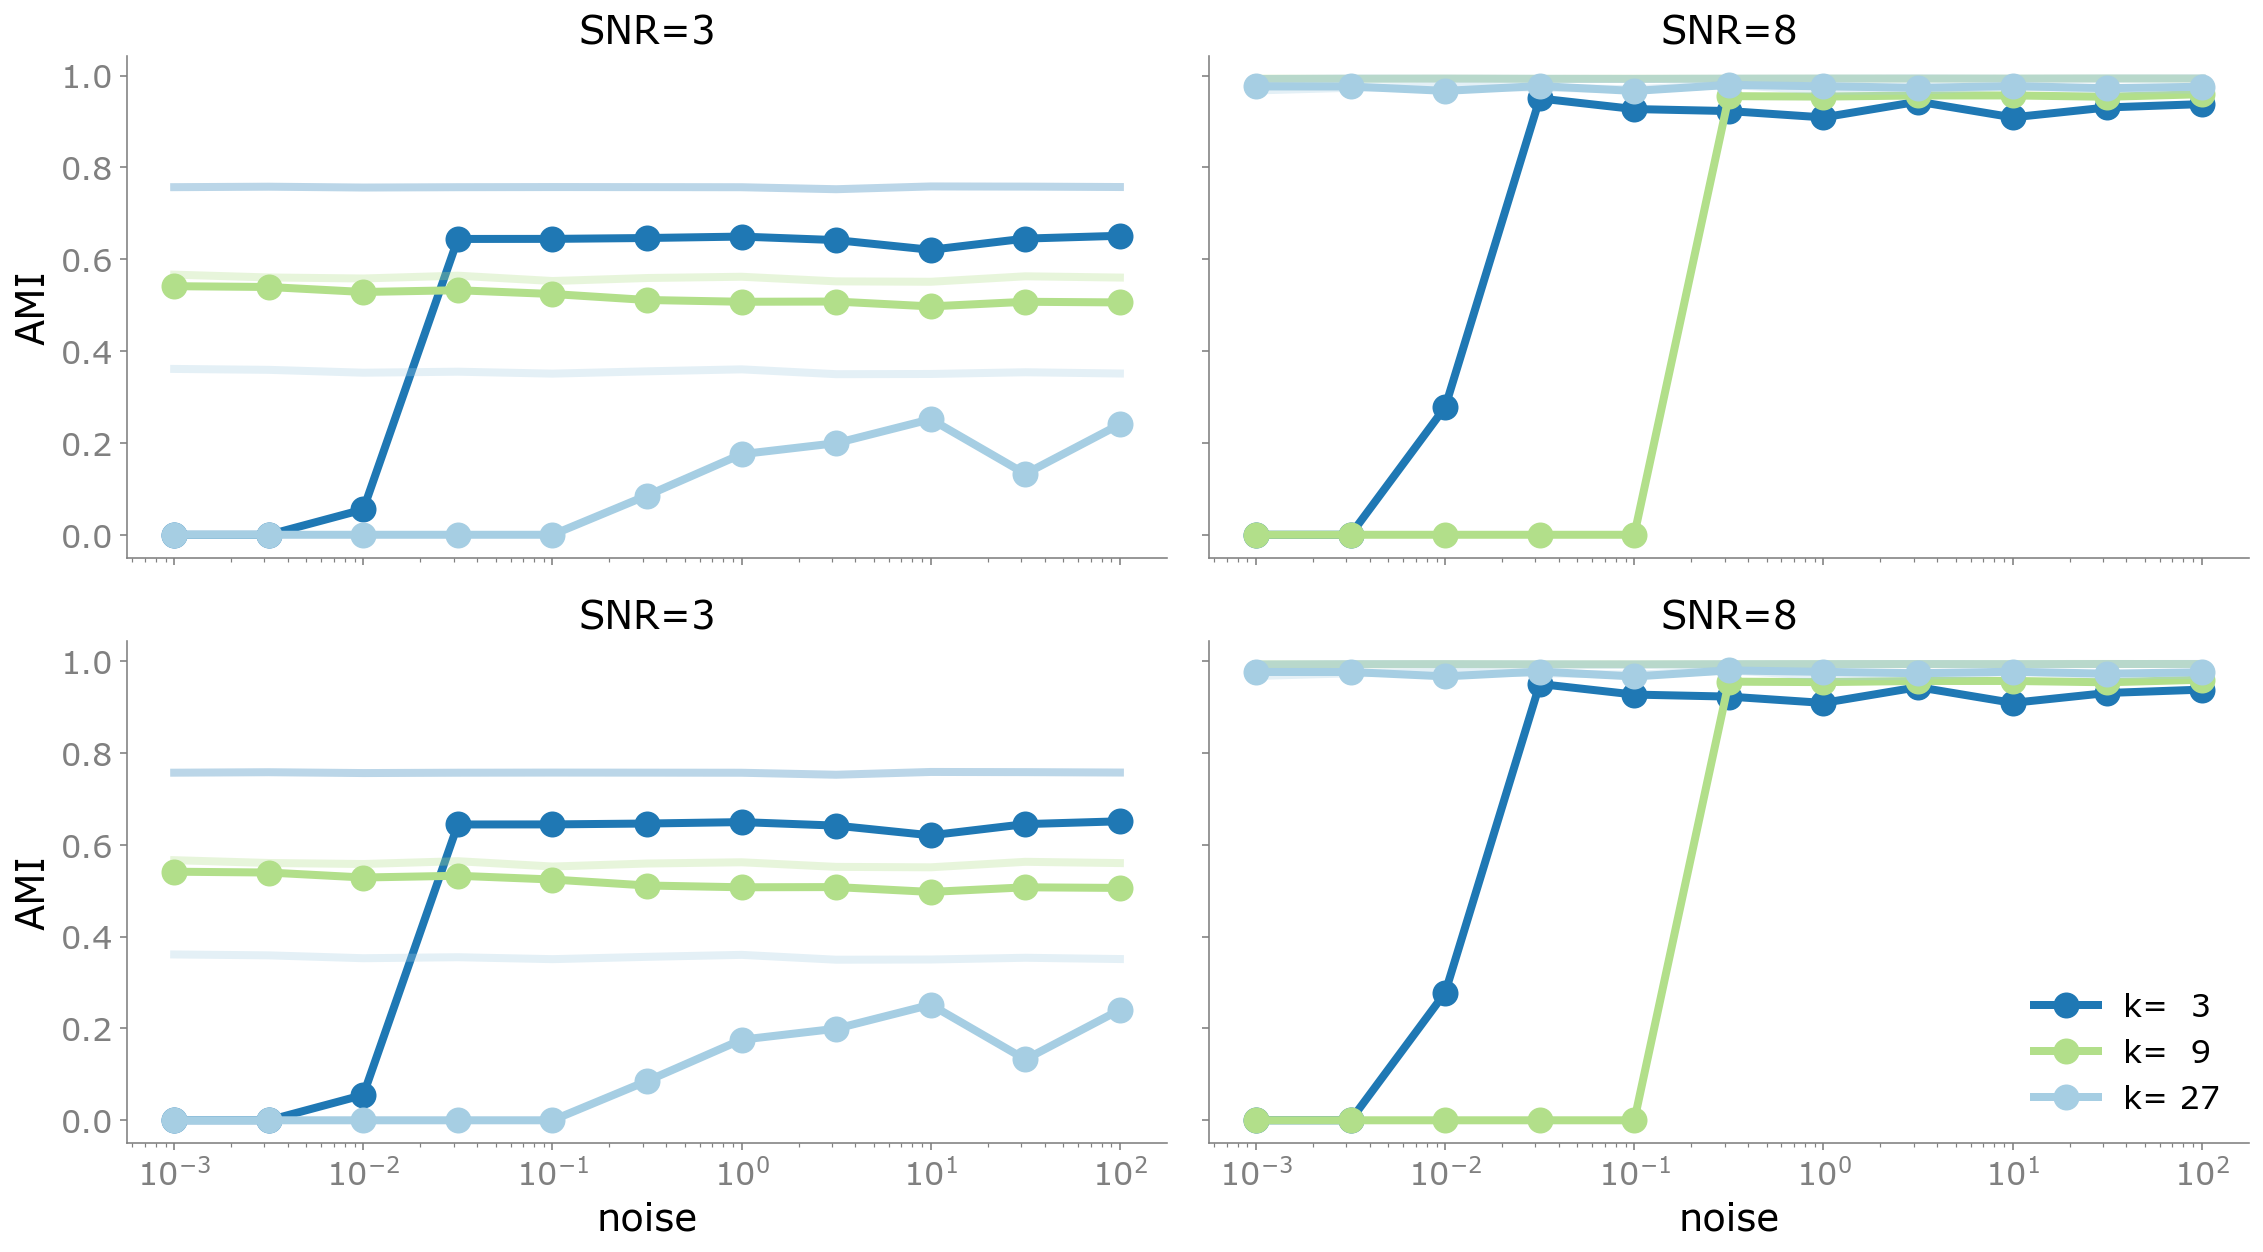

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(16, 9), sharex=True, sharey=True)
# snrs = np.array([2, 3, 4, 8])
# npows = np.linspace(-3,-1, 7)

# fileid = f'8-5noise{npows[0]:.4f}'
# mean_scores = read_mean_scores(True, fileid)
# rows, cols = mean_scores.shape

# scores = np.empty((len(npows)*rows, cols+1))
# # scores[:rows, 0] = npows[0]
# # scores[:rows, 1:] = mean_scores

# # precision = mean_scores[:, 0]
# # recall = mean_scores[:, 1]
# # n_levels = mean_scores[:, 2]
# # lvl_scores = mean_scores[:, 3:6]
# # n_groups = mean_scores[:, 6:9]
# # lvl_scores_with_k = mean_scores[:, 9:12]

# for ni, npow in enumerate(npows):
# #     print(f'Noise = {2*10**npow:}')
#     fileid = f'8-5noise{npow:.4f}'
#     mean_scores = read_mean_scores(True, fileid)
# #     print(mean_scores.shape)
#     scores[ni*rows:(ni+1)*rows, 0] = npow
#     scores[ni*rows:(ni+1)*rows, 1:] = mean_scores

# print('scores read')
    
for snr, ax in zip(snrs, axs.ravel()):

#     print(f'snr={snr}')
    snr_scores = scores[scores[:, 1]==snr, :]
#     print(snr_scores.shape)
    npows = snr_scores[:, 0]
    lvl_scores = snr_scores[:, 5:8]
    n_groups = snr_scores[:, 8:11]
    lvl_scores_with_k = snr_scores[:, 11:14]
#     n_levels = snr_scores[:, 4]
    
#     ax.plot(npows, precision, color=color0, label='Precision')
#     ax.plot(npows, recall, color=color2, label='Recall')
    group_sizes = [3, 9, 27]
    for i in range(3):
        ax.semilogx(10**npows, lvl_scores[:, i], 'o-', color=colors[i], label=f'k={group_sizes[i]:3}')
        ax.semilogx(10**npows, lvl_scores_with_k[:, i], color=colors[i], ls='-', alpha=0.3)
    
    ax.set(title=f'SNR={snr}')
    
    
axs[0,0].set(ylabel='AMI')
axs[1,0].set(ylabel='AMI')
axs[1,1].legend(frameon=False)
axs[1,1].set(xlabel='noise')
axs[1,0].set(xlabel='noise')
plt.tight_layout()
plt.savefig(f'noiseAMI_{fileid}.pdf')

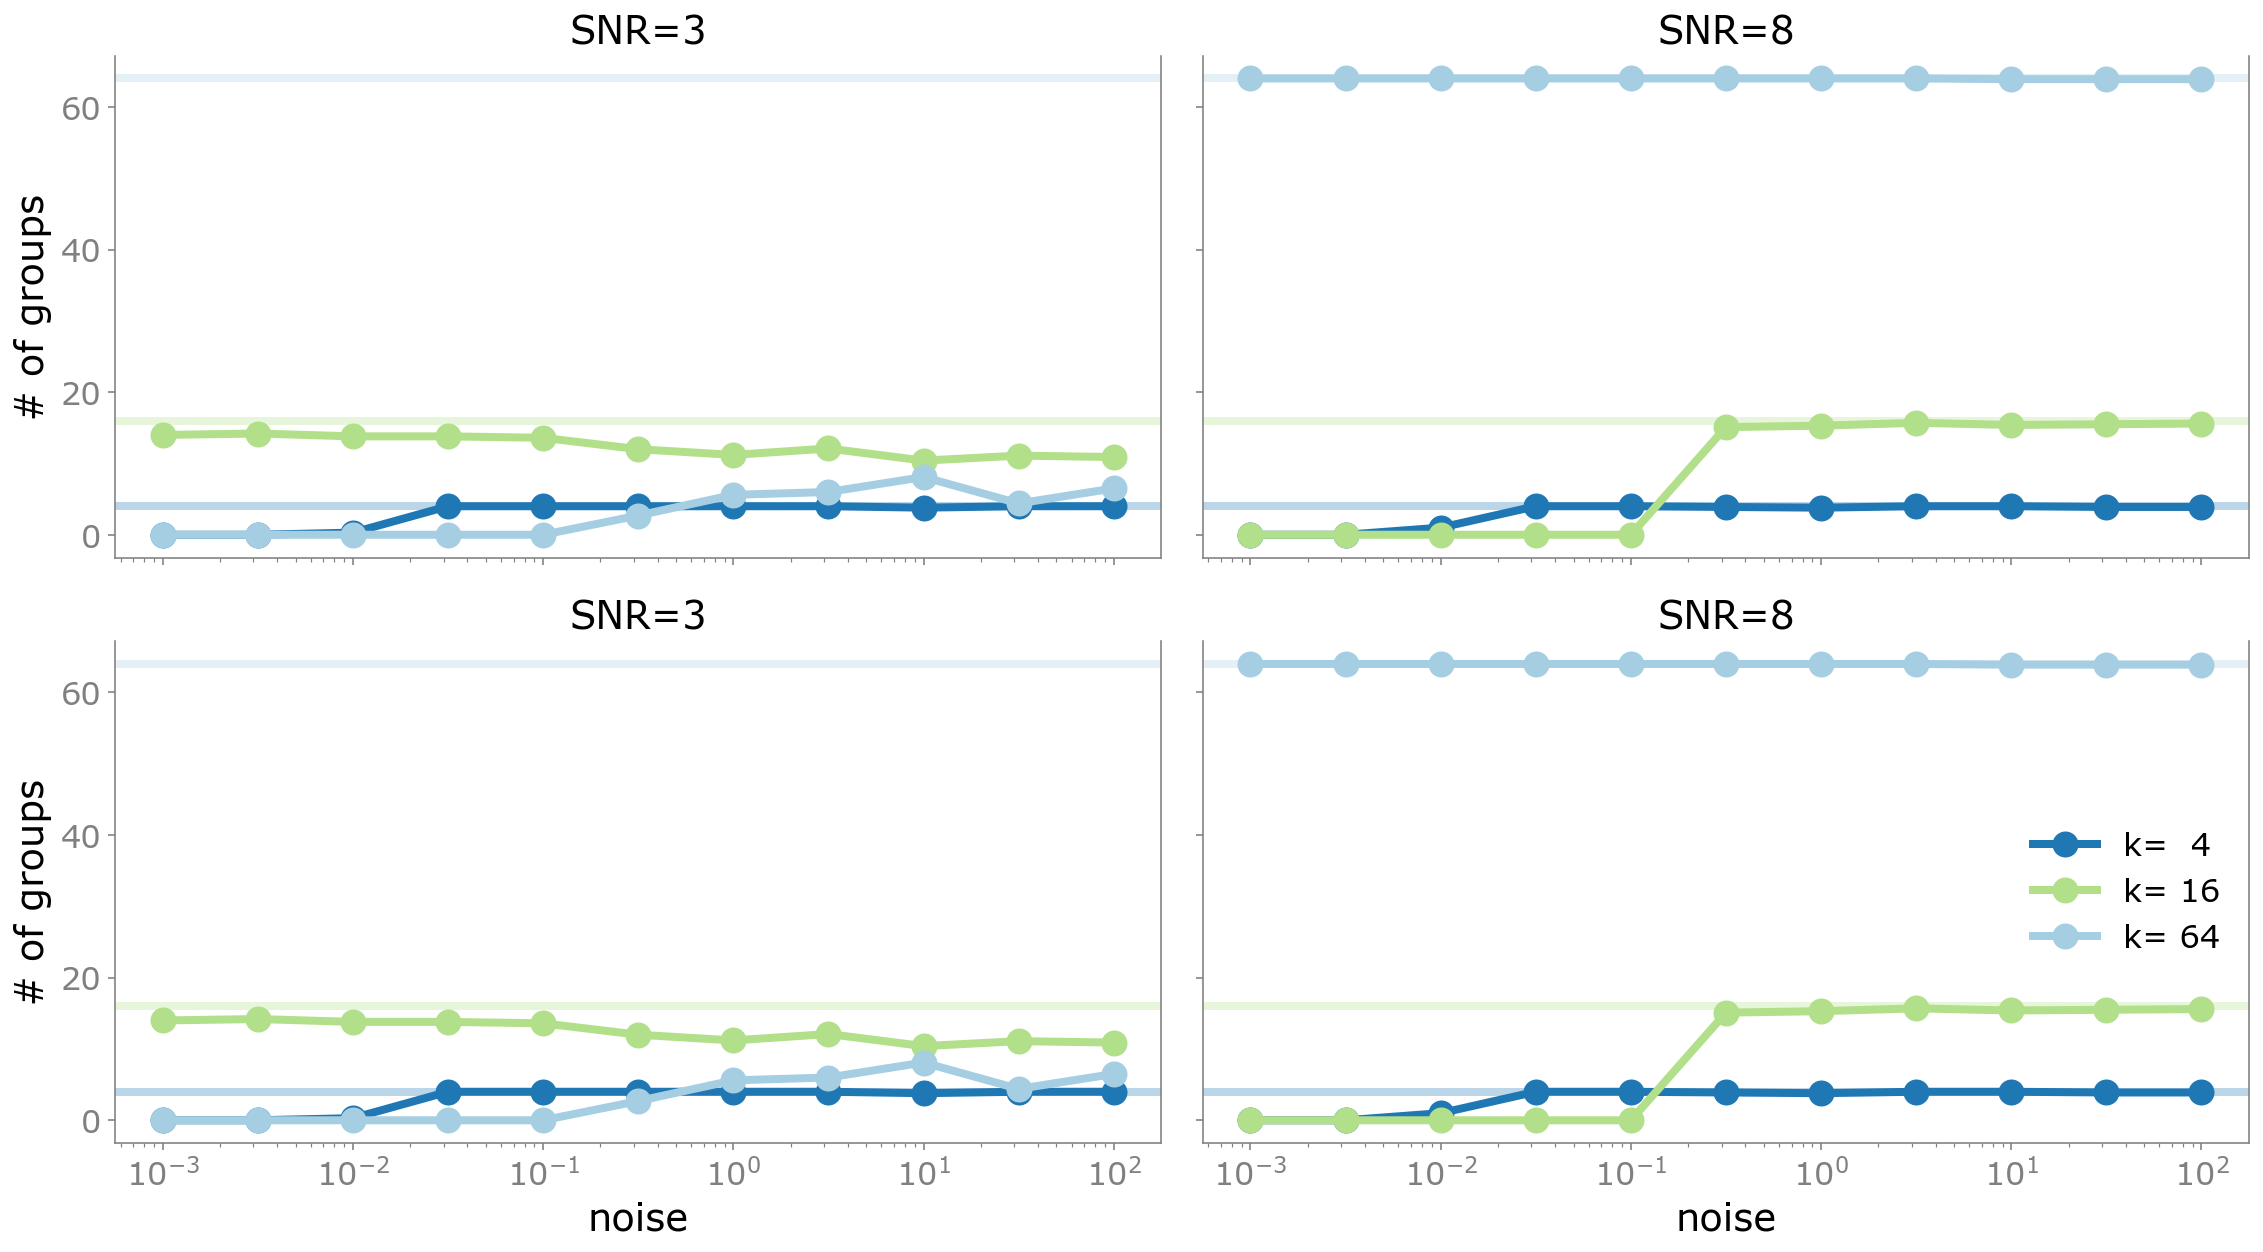

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(16, 9), sharex=True, sharey=True)
    
for snr, ax in zip(snrs, axs.ravel()):

#     print(f'snr={snr}')
    snr_scores = scores[scores[:, 1]==snr, :]
#     print(snr_scores.shape)
    npows = snr_scores[:, 0]
    lvl_scores = snr_scores[:, 5:8]
    n_groups = snr_scores[:, 8:11]
    lvl_scores_with_k = snr_scores[:, 11:14]
#     n_levels = snr_scores[:, 4]
    
#     ax.plot(npows, precision, color=color0, label='Precision')
#     ax.plot(npows, recall, color=color2, label='Recall')
    group_sizes = [3, 9, 27]
    group_sizes = [4, 16, 64]
#     for i in range(3):
#         ax.semilogx(10**npows, lvl_scores[:, i], color=colors[i], label=f'k={group_sizes[i]:3}')
#         ax.semilogx(10**npows, lvl_scores_with_k[:, i], color=colors[i], ls=':')
    
    ax.set(title=f'SNR={snr}')
    
#     ax2 = ax.twinx()
    for i in range(3):
        ax.semilogx(10**npows, n_groups[:, i], 'o-', color=colors[i], label=f'k={group_sizes[i]:3}')
        ax.axhline(group_sizes[i], ls='-', color=colors[i], alpha=0.3)
#     ax.set_ylabel('# of Levels')
    ax.spines['right'].set_visible(True)
    ax.tick_params(axis='y')
#     ax2.set_ylim(-0.05, 5.05)
    
axs[0,0].set(ylabel='# of groups')
axs[1,0].set(ylabel='# of groups')
axs[1,1].set(xlabel='noise')
axs[1,0].set(xlabel='noise')
axs[1,1].legend(frameon=False)
plt.tight_layout()
plt.savefig(f'noiseK_{fileid}.pdf')

In [69]:
np.linspace(-3, 0, 25)

array([-3.   , -2.875, -2.75 , -2.625, -2.5  , -2.375, -2.25 , -2.125,
       -2.   , -1.875, -1.75 , -1.625, -1.5  , -1.375, -1.25 , -1.125,
       -1.   , -0.875, -0.75 , -0.625, -0.5  , -0.375, -0.25 , -0.125,
        0.   ])

In [151]:
def read_gamma_scores(sym, fileid):
    precision = []
    recall = []
    lvl_scores = []
    n_levels = []
    mean_scores = []
    if sym:
        results_file = f'results_me/sym_results{fileid}.txt'
    else:
        results_file = f'results_me/asym_results{fileid}.txt'
    with open(results_file) as rfile:
        results = np.float64([row.strip().split() for row in rfile.readlines()])
    snrs = np.unique(results[:,0])
    gammas = np.unique(results[:,1])
    for snr in snrs:
        for gamma in gammas:
            idx = (results[:, 0]==snr) * (results[:, 1]==gamma)
            snr_res = results[idx, :]
            mean_scores.append(np.mean(snr_res, 0))
    mean_scores = np.array(mean_scores)
    
    return mean_scores

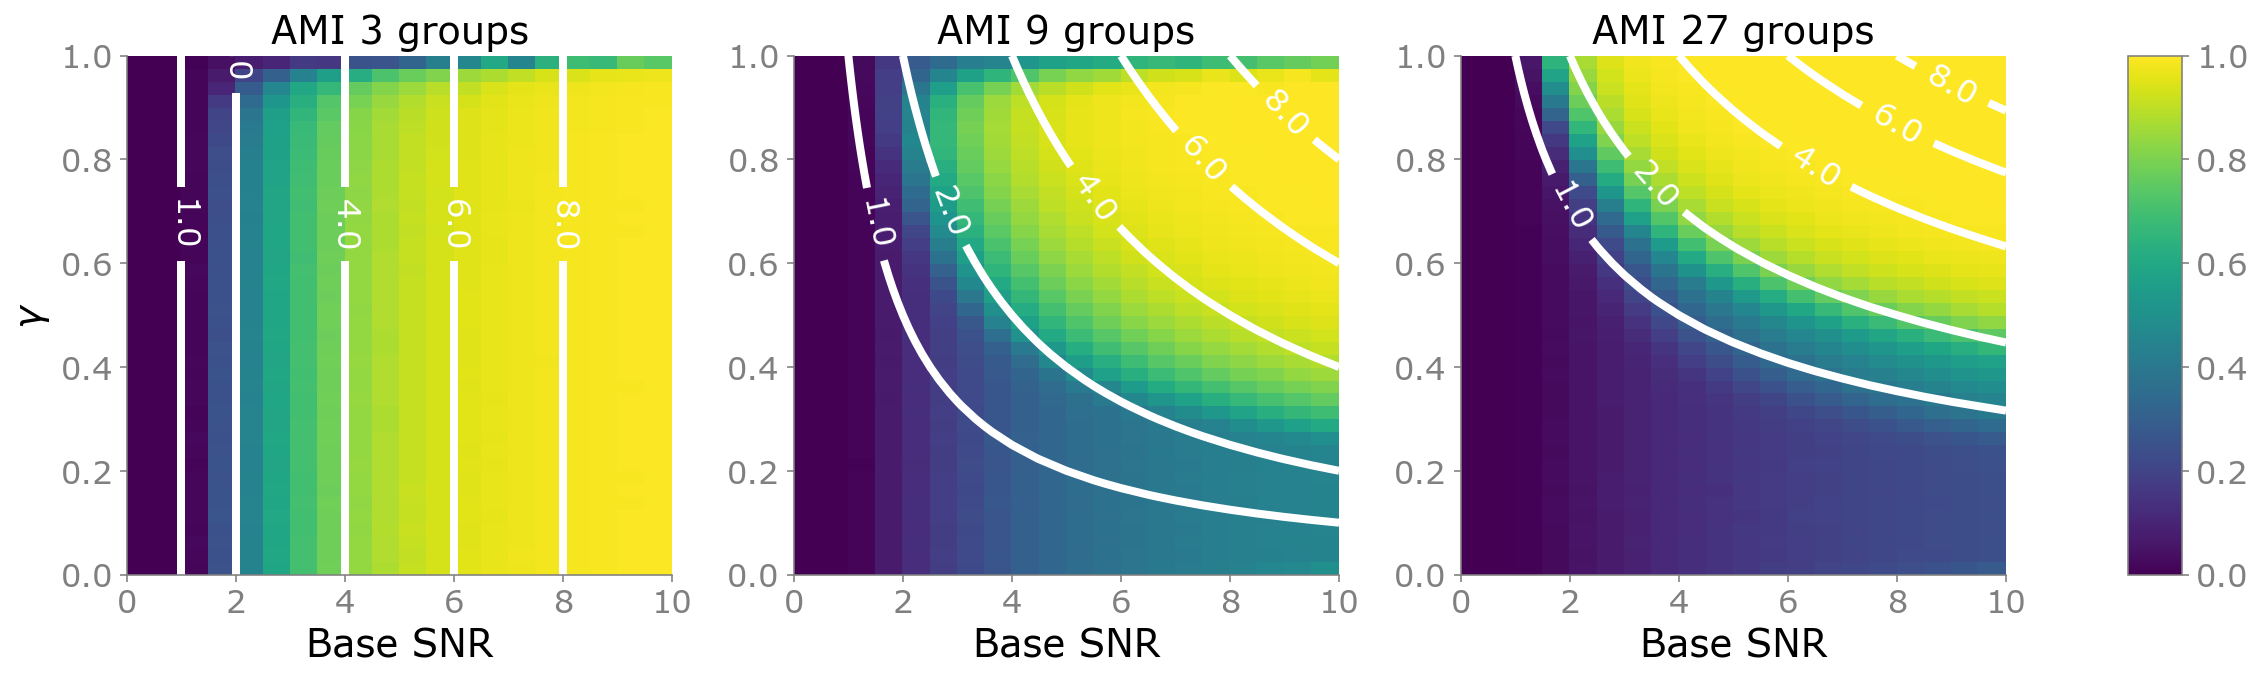

In [284]:
fileid = '27-5gamma-3-3'
mean_scores = read_gamma_scores(True, fileid)
nlevels = mean_scores.shape[1] - 2
snrs = np.unique(mean_scores[:,0])
gammas = np.unique(mean_scores[:,1])

snr_to_idx = dict((s, k) for k, s in enumerate(snrs))
gam_to_idx = dict((f'{g:.4f}', k) for k, g in enumerate(gammas))

snr_v_gam = [np.zeros((len(gammas), len(snrs))) for _ in range(nlevels)]

for scores in mean_scores:
    snr = snr_to_idx[scores[0]]
    gam = gam_to_idx[f'{scores[1]:.4f}']
    for lvl in range(nlevels):
        snr_v_gam[lvl][gam, snr] = scores[lvl+2]

x, y = np.meshgrid(snrs, gammas)

fig = plt.figure(figsize=(16, 5))
widths = [5, 5, 5, .5]
heights = [5]
spec5 = fig.add_gridspec(ncols=nlevels+1, nrows=1, width_ratios=widths,
                           height_ratios=heights)

# fig, axs = plt.subplots(1, nlevels+1, figsize=(16, 5), sharex=True, sharey=True)
Ks = [3, 9, 27]

fmt = r'%r'

for lvl in range(nlevels):
    ax = fig.add_subplot(spec5[0, lvl])
    im = ax.pcolormesh(x, y, snr_v_gam[lvl], vmin=0, vmax=1)
    cs = ax.contour(x, y, x*(y**lvl), [1,2,4,6,8], colors='w')
    ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=16)
    ax.set(title=f'AMI {Ks[lvl]} groups', xlabel='Base SNR')
    if lvl == 0:
        ax.set(ylabel=r'$\gamma$')
ax = fig.add_subplot(spec5[0, nlevels])
fig.colorbar(im, cax=ax)
plt.tight_layout()

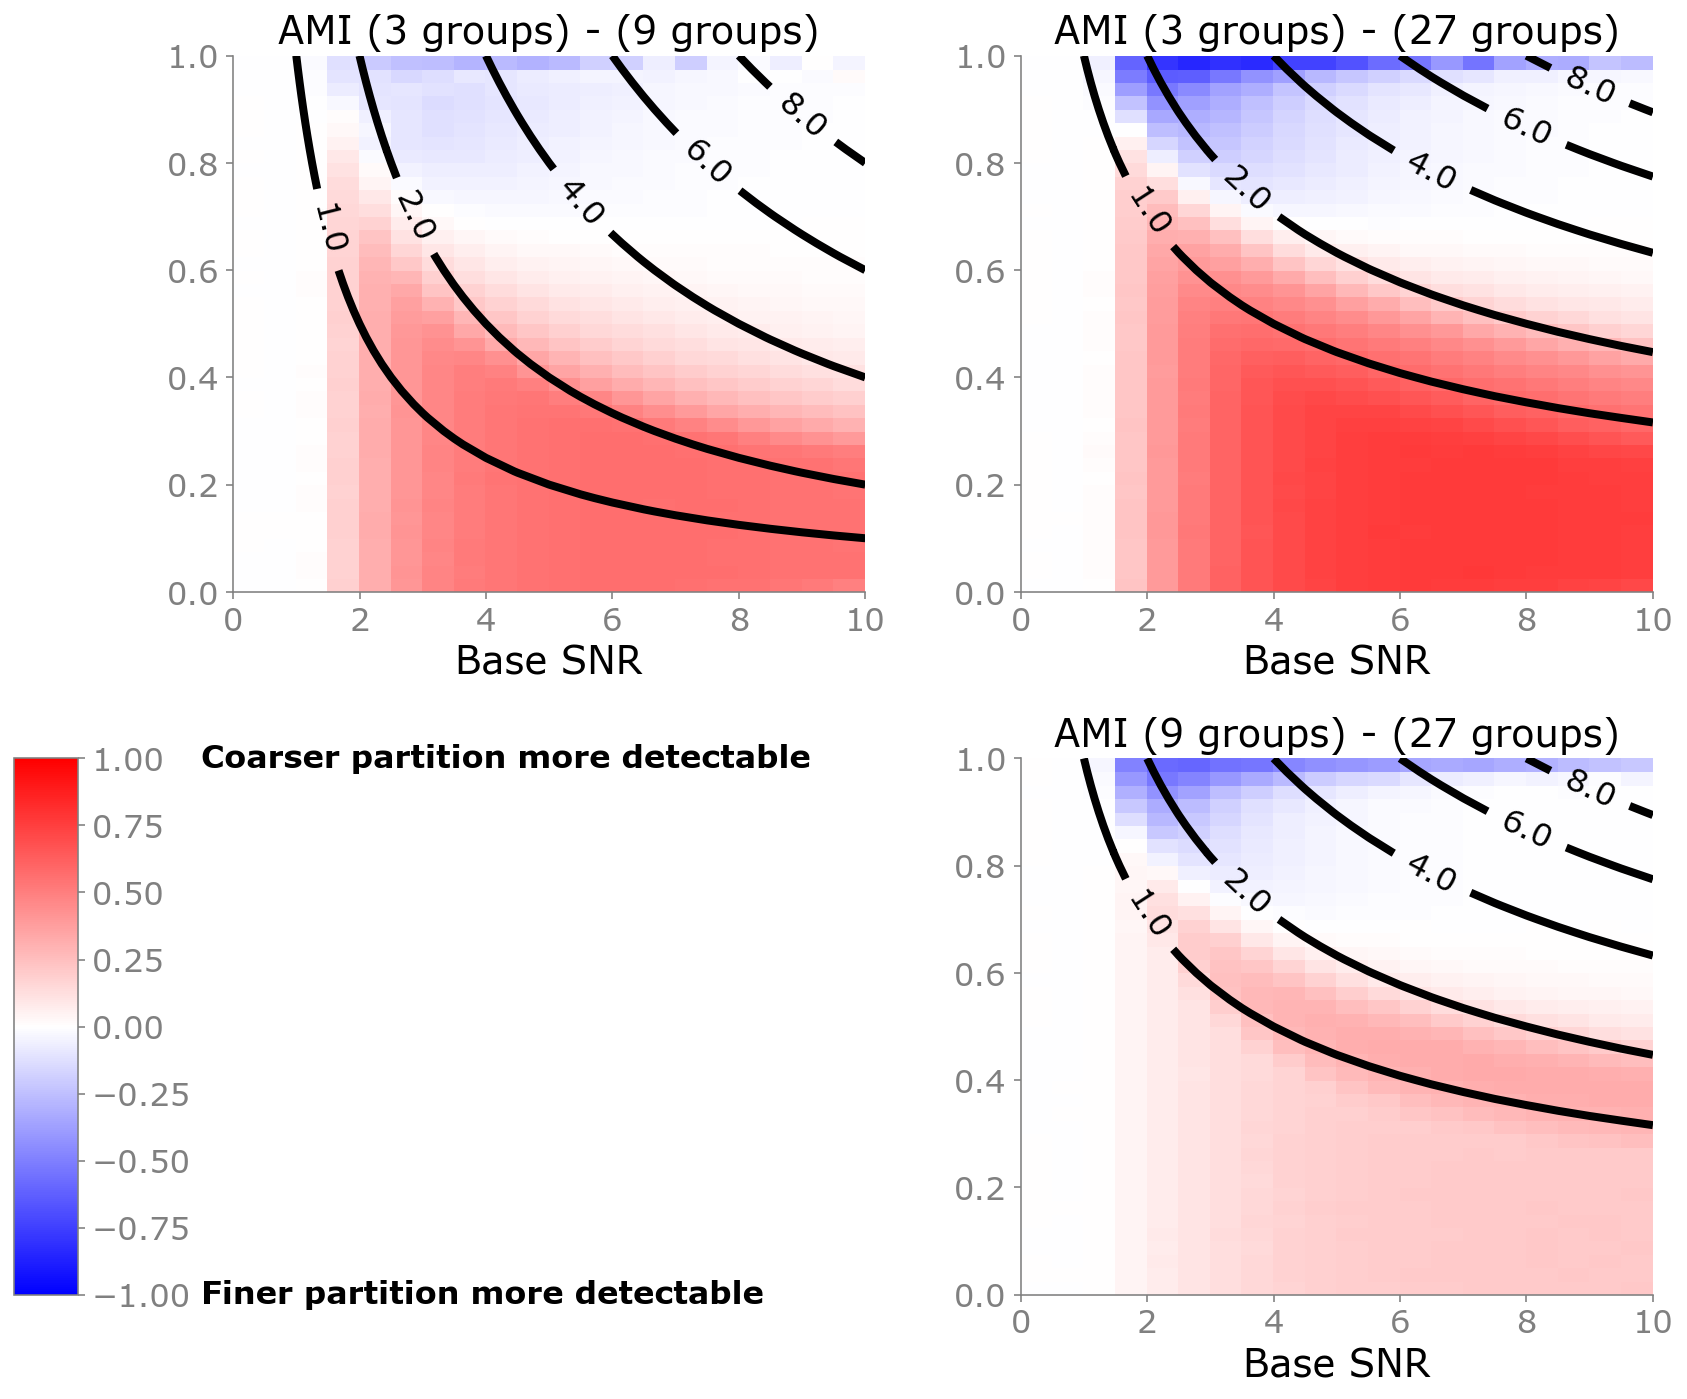

In [279]:
fileid = '27-5gamma-3-3'
mean_scores = read_gamma_scores(True, fileid)
nlevels = mean_scores.shape[1] - 2
snrs = np.unique(mean_scores[:,0])
gammas = np.unique(mean_scores[:,1])

snr_to_idx = dict((s, k) for k, s in enumerate(snrs))
gam_to_idx = dict((f'{g:.4f}', k) for k, g in enumerate(gammas))

snr_v_gam = [np.zeros((len(gammas), len(snrs))) for _ in range(nlevels)]

for scores in mean_scores:
    snr = snr_to_idx[scores[0]]
    gam = gam_to_idx[f'{scores[1]:.4f}']
    for lvl in range(nlevels):
        snr_v_gam[lvl][gam, snr] = scores[lvl+2]

x, y = np.meshgrid(snrs, gammas)

fig = plt.figure(figsize=(12, 10))
widths = [.5] + [5]*(nlevels-1)
heights = [5]*(nlevels-1)
spec5 = fig.add_gridspec(ncols=nlevels, nrows=nlevels-1, width_ratios=widths,
                           height_ratios=heights)

# fig, axs = plt.subplots(1, nlevels+1, figsize=(16, 5), sharex=True, sharey=True)
Ks = [3, 9, 27]

for lvli in range(nlevels):
    for lvlj in range(lvli+1, nlevels):
        ax = fig.add_subplot(spec5[lvli, lvlj])
        im = ax.pcolormesh(x, y, snr_v_gam[lvli] - snr_v_gam[lvlj], vmin=-1, vmax=1, cmap=plt.get_cmap('bwr'))
#         cs = ax.contour(x, y, x*(y**lvli - y**lvlj), 5, colors='k')
        cs = ax.contour(x, y, x*(y**lvlj), [1,2,4,6,8], colors='k')
#         cs = ax.contour(x, y, snr_v_gam[lvli] - snr_v_gam[lvlj], [0], colors='k')
        ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=16)
        ax.set(title=f'AMI ({Ks[lvli]} groups) - ({Ks[lvlj]} groups)', xlabel='Base SNR')
        if lvlj == 0:
            ax.set(ylabel=r'$\gamma$')
            
ax = fig.add_subplot(spec5[1, 0])
fig.colorbar(im, cax=ax)

ax = fig.add_subplot(spec5[1, 1])
ax.annotate('Coarser partition more detectable', (-0.05, 1), xycoords='axes fraction', va='center', size=16, weight='bold')
ax.annotate('Finer partition more detectable', (-0.05, 0), xycoords='axes fraction', va='center', size=16, weight='bold')
ax.spines['bottom'].set(visible=False)
ax.spines['left'].set(visible=False)
ax.set(xticks=[], yticks=[])
plt.tight_layout()

In [273]:
# QUESTION: can we change the function f(gamma, snr) such that the above plots have horizontal bars?
# Repeat the above plots with the snr (instead of AMI),
# 2 ways: (a) using average cout and (b) using eigenvalues

/home/leto/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: No contour levels were found within the data range.


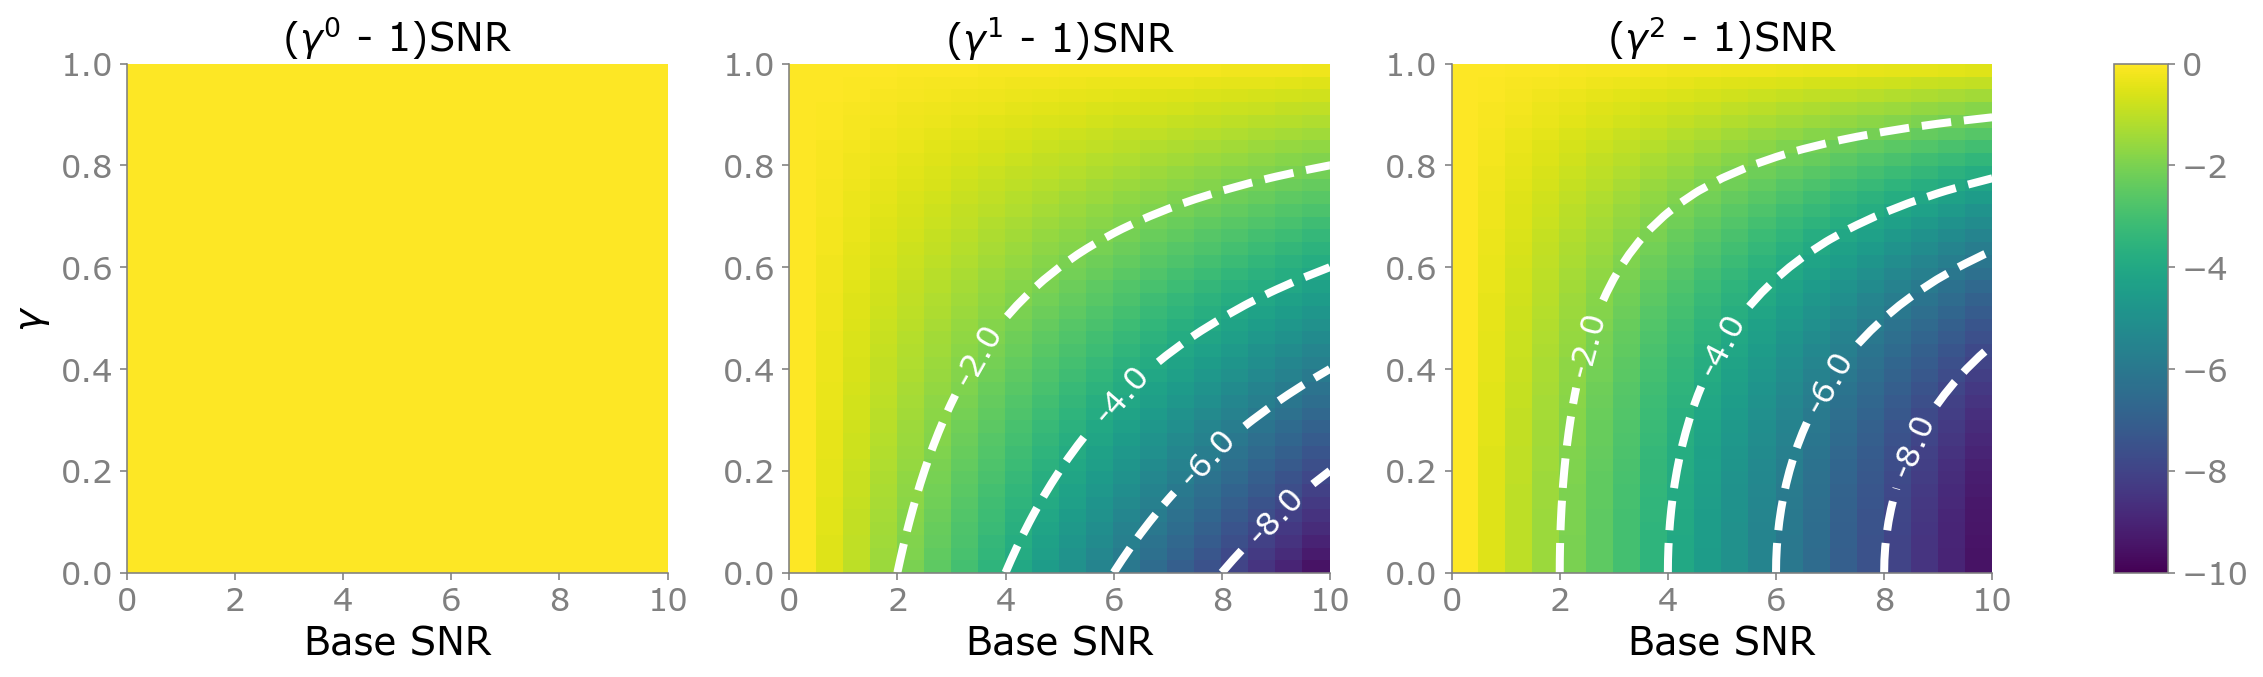

In [306]:
# fileid = '27-5gamma-3-3'
mean_scores = read_gamma_scores(True, fileid)
nlevels = mean_scores.shape[1] - 2
snrs = np.unique(mean_scores[:,0])
gammas = np.unique(mean_scores[:,1])

snr_to_idx = dict((s, k) for k, s in enumerate(snrs))
gam_to_idx = dict((f'{g:.4f}', k) for k, g in enumerate(gammas))

snr_v_gam = [np.zeros((len(gammas), len(snrs))) for _ in range(nlevels)]

for scores in mean_scores:
    snr = snr_to_idx[scores[0]]
    gam = gam_to_idx[f'{scores[1]:.4f}']
    for lvl in range(nlevels):
        snr_v_gam[lvl][gam, snr] = scores[lvl+2]

x, y = np.meshgrid(snrs, gammas)

fig = plt.figure(figsize=(16, 5))
widths = [5, 5, 5, .5]
heights = [5]
spec5 = fig.add_gridspec(ncols=nlevels+1, nrows=1, width_ratios=widths,
                           height_ratios=heights)

# fig, axs = plt.subplots(1, nlevels+1, figsize=(16, 5), sharex=True, sharey=True)
Ks = [3, 9, 27]

fmt = r'%r'

for lvl in range(nlevels):
    ax = fig.add_subplot(spec5[0, lvl])
    im = ax.pcolormesh(x, y, x*(y**lvl)-x, vmin=-10, vmax=0)
    cs = ax.contour(x, y, x*(y**lvl)-x, 5, colors='w')
    ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=16)
    ax.set(title=f'($\gamma^{lvl}$ - 1)SNR', xlabel='Base SNR')
    if lvl == 0:
        ax.set(ylabel=r'$\gamma$')
ax = fig.add_subplot(spec5[0, nlevels])
fig.colorbar(im, cax=ax)
plt.tight_layout()

In [603]:
def checkSNR(n, omega, c_bar = 50):
    k=omega.shape[0]
    Q = omega*n
    P = np.eye(k)/k
    evals, _ = np.linalg.eigh(P @ Q)
    evals = np.sort(evals)
    ev1 = evals[-1]
    ev2 = evals[-2]
    return ev2**2/ev1

def checkSNRab(n, omega, c_bar = 50):
    k=omega.shape[0]
    a = omega[0, 0]*n
    b = np.mean(omega[0, 1:]*n)
    print(f'a:{a:.2f} b:{b:.2f}')
    return ((a-b)**2) / (k*(a+(k-1)*b))

def checkSNRup(n, omega, k, c_bar = 50):
#     print(k, omega.shape[0])
    kmax=omega.shape[0]
    a = np.mean(omega[0, :k]*n)
    b = np.mean(omega[0, k:]*n)
    print(f'a:{a:.2f} b:{b:.2f}')
    k=kmax/k
    return ((a-b)**2) / (k*(a+(k-1)*b))

In [604]:
n = 3**9
gamma = .8
snr=10
k=3
omega1 = generation.calculate2paramOmega(n, snr, c_bar=c_bar, groups_per_level=k, gamma=gamma, level=1)
checkSNR(n, omega1), checkSNRab(n, omega1)

KS Detectable:  True | Link Probabilities in / out per block:  0.004812343623939227 0.001404222944927201
Number of nodes: 19683 | In / out degree: 94.7213595499958 / 27.6393202250021
a:94.72 b:27.64


(10.000000000000005, 10.000000000000004)

In [605]:
cout1 = omega1[0, -1]
omega2_part = generation.calculate2paramOmega(n, snr, c_bar=c_bar, groups_per_level=k, gamma=gamma, level=2)
omega2 = np.kron(np.eye(k), omega2_part)
omega2[(omega2==0).nonzero()] = cout1
checkSNR(n, omega2), checkSNRab(n, omega2), checkSNRup(n, omega2, k)

KS Detectable:  True | Link Probabilities in / out per block:  0.010669105319311081 0.0018839627762532998
Number of nodes: 19683 | In / out degree: 210.0 / 37.0820393249937
a:210.00 b:30.00
a:94.72 b:27.64


(10.000000000000002, 8.000000000000004, 10.000000000000009)

In [606]:
cout2 = omega2_part[0, -1]
omega3_part2 = generation.calculate2paramOmega(n, snr, c_bar=c_bar, groups_per_level=k, gamma=gamma, level=3)
omega3_part = np.kron(np.eye(3), omega3_part2)
omega3_part[(omega3_part==0).nonzero()] = cout2

omega3 = np.kron(np.eye(3), omega3_part)
omega3[(omega3==0).nonzero()] = cout1

checkSNR(n, omega3), checkSNRab(n, omega3), checkSNRup(n, omega3, k), checkSNRup(n, omega3, k*k)

KS Detectable:  True | Link Probabilities in / out per block:  0.026169899879081256 0.002918708039425998
Number of nodes: 19683 | In / out degree: 515.1021393199563 / 57.44893034002192
a:515.10 b:32.11
a:210.00 b:30.00
a:94.72 b:27.64


(10.000000000000021, 6.400000000000001, 8.000000000000004, 10.000000000000009)

In [607]:
1.58**(.5)

1.2569805089976536

In [772]:
n = 4**7
k = 2
gamma = .9
snr=10
c_bar=50
omega1 = generation.calculate2paramOmega(n, snr, c_bar=c_bar, groups_per_level=k, gamma=gamma, level=1)
checkSNR(n, omega1), checkSNRab(n, omega1)

KS Detectable:  True | Link Probabilities in / out per block:  0.004416545396423211 0.0016869702285767884
Number of nodes: 16384 | In / out degree: 72.36067977499789 / 27.639320225002102
a:72.36 b:27.64


(9.999999999999998, 9.999999999999998)

In [773]:
cout1 = omega1[0, -1]
omega2_part = generation.calculate2paramOmega(n, snr, c_bar=c_bar, groups_per_level=k, gamma=gamma, level=2)
omega2 = np.kron(np.eye(k), omega2_part)
omega2[(omega2==0).nonzero()] = cout1
checkSNR(n, omega2), checkSNRab(n, omega2), checkSNRup(n, omega2, k)

KS Detectable:  True | Link Probabilities in / out per block:  0.006936011371263994 0.001897079421582429
Number of nodes: 16384 | In / out degree: 113.63961030678928 / 31.081749243206517
a:113.64 b:28.79
a:72.36 b:27.64


(9.999999999999998, 9.000000000000002, 9.999999999999998)

In [785]:
from collections import Counter
k=2
snr = 25
c_bar = 150
dendro = generation.create2paramGHRG(n, snr, c_bar, 2, k, .1)
Aa = dendro.sample_network()


combined_evecs = evecs_from_BetheHessian(Aa, num_groups=k*k)
for true_part in dendro:
    k = true_part.k
    inf_part = cluster.find_partition(combined_evecs, k, normalization=parameters['BHnorm'])
    ami = metrics.adjusted_mutual_info_score(inf_part.pvec, 
                                             true_part.pvec_expanded,
                                             average_method="arithmetic")
    print(f'k:{k} ami:{ami:.3f}', Counter(inf_part.pvec))

Hierarchy Level:  1
KS Detectable:  True | Link Probabilities in / out per block:  0.01289289816708859 0.005417648707911411
Number of nodes: 16384 | In / out degree: 211.23724356957945 / 88.76275643042055
Hierarchy Level:  2
KS Detectable:  True | Link Probabilities in / out per block:  0.012701095592841263 0.013084700741335914
Number of nodes: 16384 | In / out degree: 208.09475019311125 / 214.37973694604761
k:2 ami:1.000 Counter({1: 8192, 0: 8192})
k:4 ami:0.457 Counter({1: 4177, 0: 4099, 3: 4096, 2: 4012})


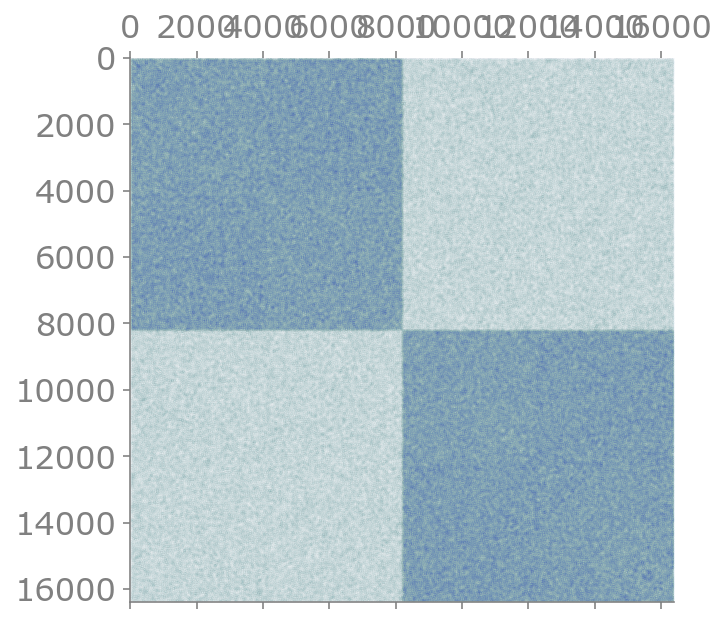

In [786]:
plt.spy(Aa, marker='.', ms=0.01, rasterized=True)

In [703]:
n = 4 ** 7
k=4
pvec4 = np.kron(np.arange(k), np.ones(int(n/k)))
k=2
pvec2 = np.kron(np.arange(k), np.ones(int(n/k)))
metrics.adjusted_mutual_info_score(pvec4, pvec2)

0.6666373078954527

In [704]:
for g in range(k):
    pvec2[int(g*n/k):int((g+1)*n/k)] = np.random.permutation(pvec4[int(g*n/k):int((g+1)*n/k)])

metrics.adjusted_mutual_info_score(pvec4, pvec2)

0.4999841971920761

In [715]:
k=4
pvec4 = np.kron(np.arange(k), np.ones(int(n/k)))
pvec4[pvec4==1] = 1
pvec4[pvec4==2] = 1
pvec4[pvec4==3] = 1
k=2
pvec2 = np.kron(np.arange(k), np.ones(int(n/k)))
metrics.adjusted_mutual_info_score(pvec4, pvec2)

0.3436791072859511

In [770]:
np.linspace(0,2,81)

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
       0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
       0.9  , 0.925, 0.95 , 0.975, 1.   , 1.025, 1.05 , 1.075, 1.1  ,
       1.125, 1.15 , 1.175, 1.2  , 1.225, 1.25 , 1.275, 1.3  , 1.325,
       1.35 , 1.375, 1.4  , 1.425, 1.45 , 1.475, 1.5  , 1.525, 1.55 ,
       1.575, 1.6  , 1.625, 1.65 , 1.675, 1.7  , 1.725, 1.75 , 1.775,
       1.8  , 1.825, 1.85 , 1.875, 1.9  , 1.925, 1.95 , 1.975, 2.   ])

array([22.36067977, 22.36067977, 50.        ])

In [392]:
np.linalg.eigh(P @ (omega * n))

(array([22.36067977, 22.36067977, 50.        ]),
 array([[ 0.3086067 , -0.75592895, -0.57735027],
        [-0.80895702,  0.11070323, -0.57735027],
        [ 0.50035032,  0.64522571, -0.57735027]]))

In [387]:
P

array([[0.33333333, 0.        , 0.        ],
       [0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.33333333]])

In [32]:
np.log(np.linspace(0,10,11)+1) - np.log(.5)

array([0.69314718, 1.38629436, 1.79175947, 2.07944154, 2.30258509,
       2.48490665, 2.63905733, 2.77258872, 2.89037176, 2.99573227,
       3.09104245])

In [34]:
np.log((np.linspace(0,10,11)+1)/.5)

array([0.69314718, 1.38629436, 1.79175947, 2.07944154, 2.30258509,
       2.48490665, 2.63905733, 2.77258872, 2.89037176, 2.99573227,
       3.09104245])